Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


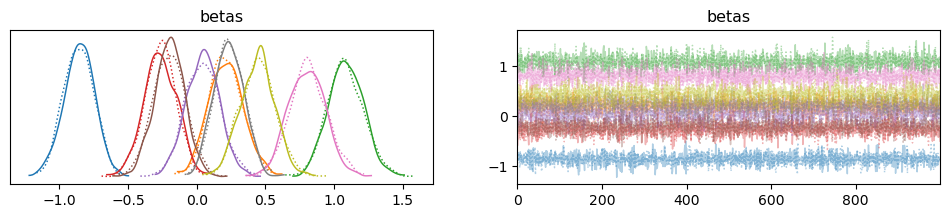

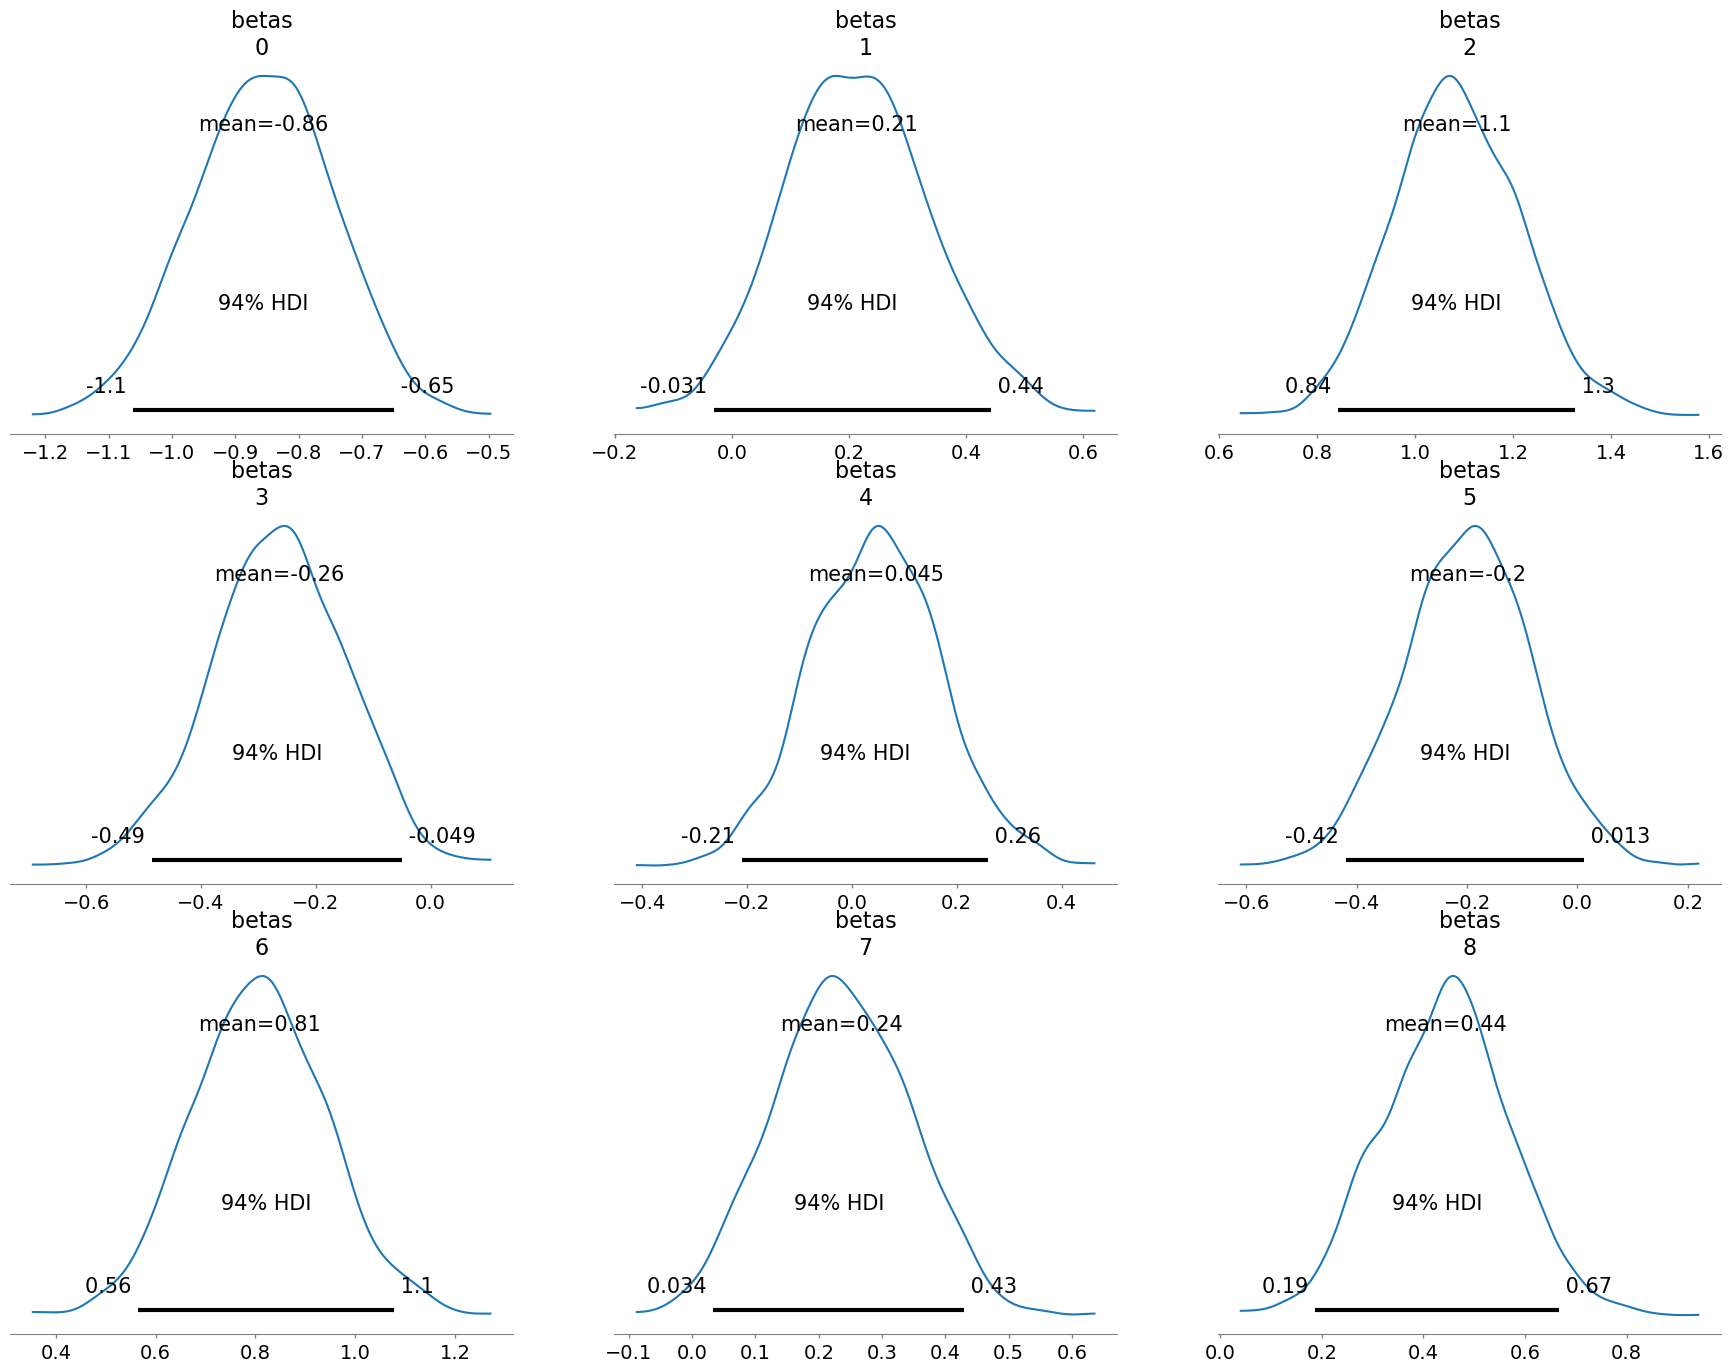

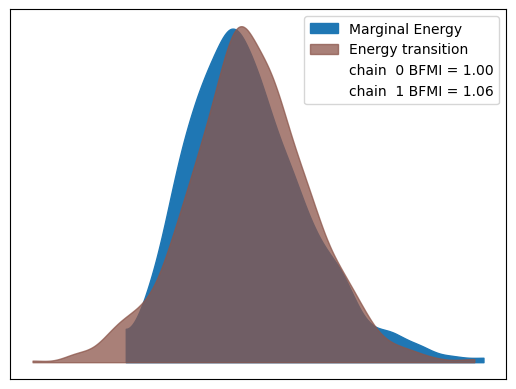

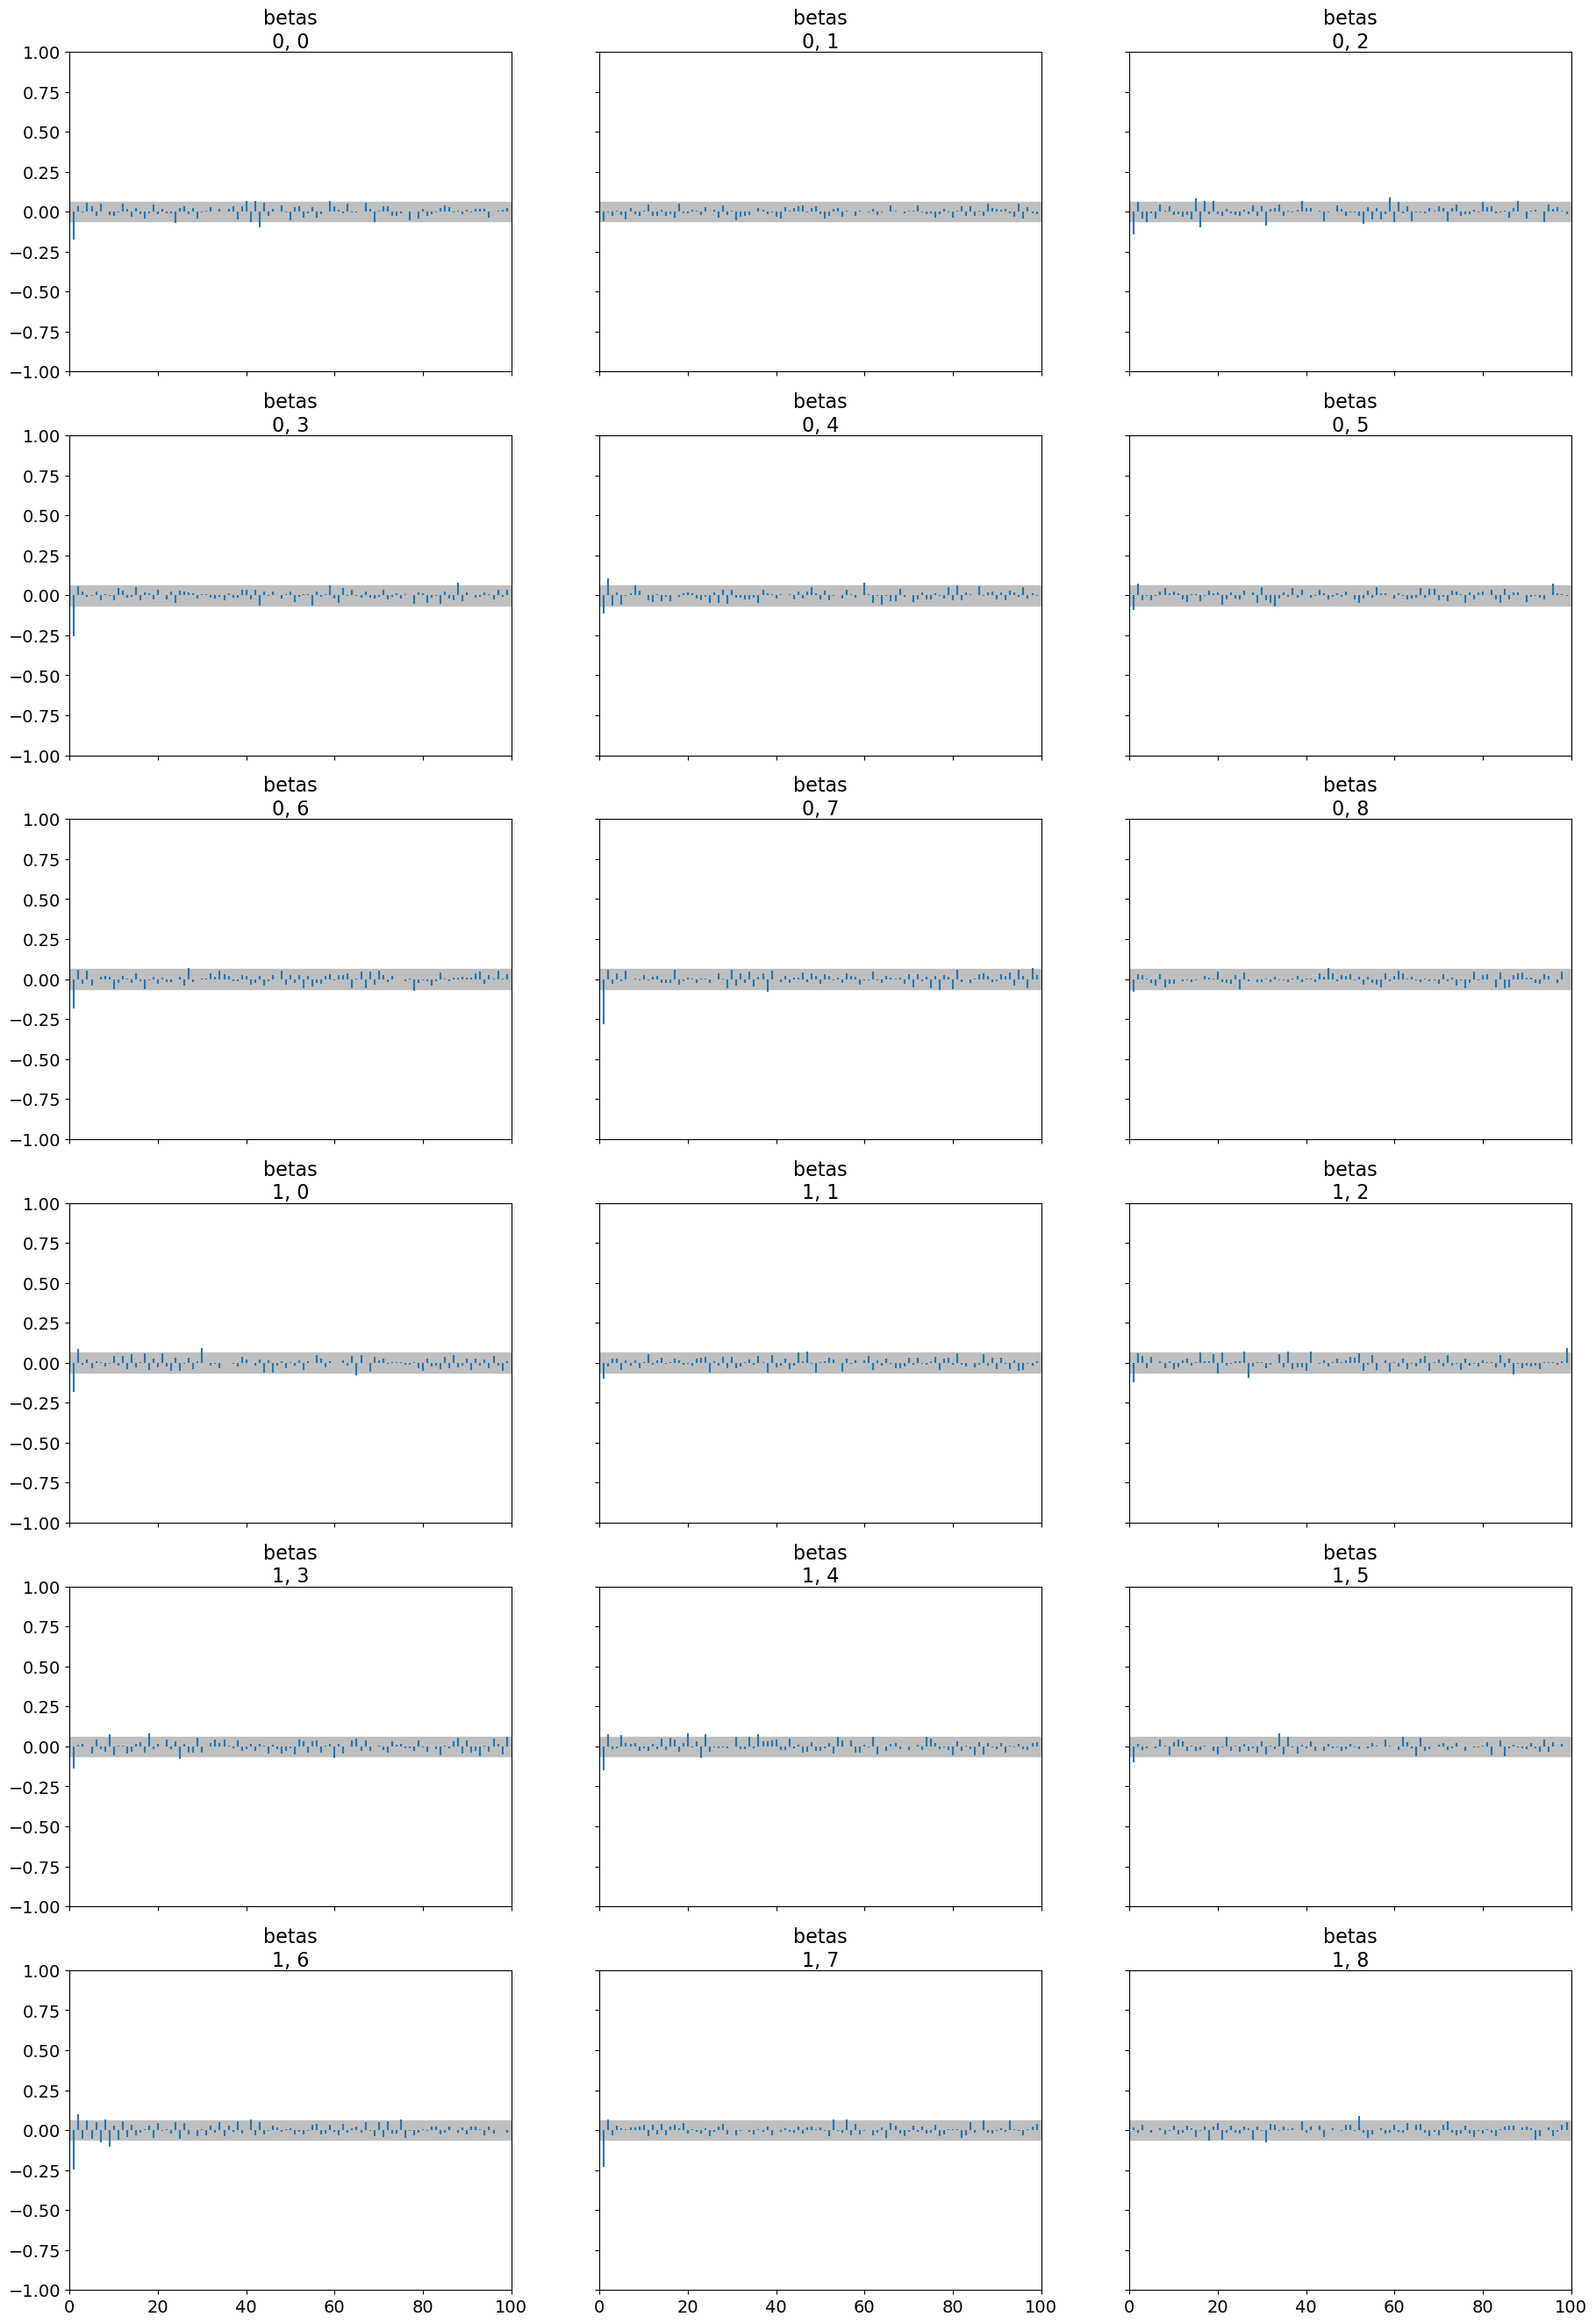

Sampling: [y_obs]


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0] -0.856  0.111  -1.061   -0.650      0.002    0.003    2377.0   
betas[1]  0.213  0.126  -0.031    0.443      0.003    0.002    2375.0   
betas[2]  1.086  0.131   0.842    1.327      0.003    0.003    2334.0   
betas[3] -0.264  0.117  -0.485   -0.049      0.002    0.003    2832.0   
betas[4]  0.045  0.124  -0.210    0.259      0.003    0.002    2229.0   
betas[5] -0.199  0.115  -0.420    0.013      0.002    0.002    2406.0   
betas[6]  0.807  0.136   0.564    1.079      0.003    0.003    2787.0   
betas[7]  0.236  0.108   0.034    0.430      0.002    0.002    2871.0   
betas[8]  0.444  0.129   0.187    0.666      0.003    0.003    1974.0   

          ess_tail  r_hat  
betas[0]    1419.0    1.0  
betas[1]    1850.0    1.0  
betas[2]    1461.0    1.0  
betas[3]    1496.0    1.0  
betas[4]    1614.0    1.0  
betas[5]    1564.0    1.0  
betas[6]    1687.0    1.0  
betas[7]    1248.0    1.0  
betas[8]    1484.

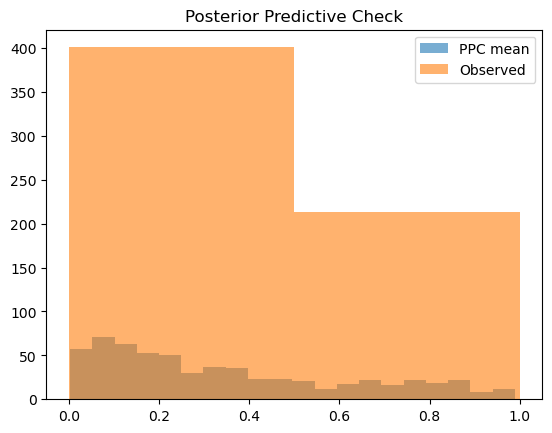

Test Accuracy: 0.75
Test AUC: 0.81


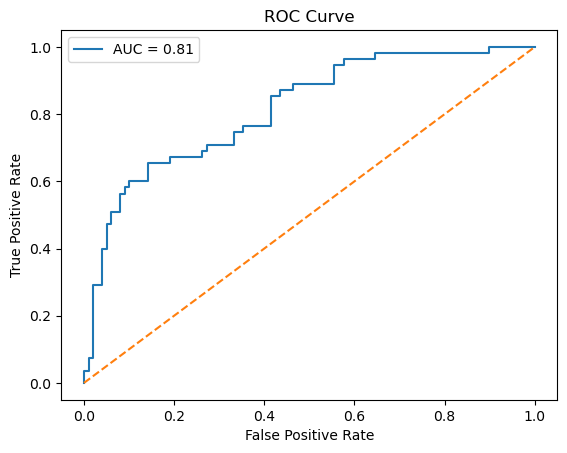

In [8]:
## Q1
## Dataset: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# read dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)
X = df.drop(columns=["Outcome"]).values
y = df["Outcome"].values
n, p = X.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# traning set & test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

#intercept
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
n_features = X_train.shape[1]

# construct bayesian logisitc regression model
with pm.Model() as logistic_model:
    # posterior
    betas = pm.Normal("betas", mu=0, sigma=1, shape=n_features)

    # linear combination
    logits = pm.math.dot(X_train, betas)

    # logit to proability
    theta = pm.Deterministic("theta", pm.math.sigmoid(logits))

    # likelihood(bernoulli)
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y_train)

    # MCMC 
    trace = pm.sample(
        1000, tune=1000, target_accept=0.9, cores=2, random_seed=42, return_inferencedata=True
    )

# diagonstics
az.plot_trace(trace, var_names=["betas"])
plt.show()

az.plot_posterior(trace, var_names=["betas"])
plt.show()

az.plot_energy(trace)
plt.show()

az.plot_autocorr(trace, var_names=["betas"])
plt.show()

# results
summary = az.summary(trace, var_names=["betas"])
print(summary)

# Posterior Predictive Check
with logistic_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42)
    
# Visualize PPC vs observed outcomes
# Extract posterior predictive samples correctly
y_pred_ppc = ppc.posterior_predictive["y_obs"].values  # shape: (chains, draws, n_samples)
y_pred_ppc_mean = y_pred_ppc.mean(axis=(0, 1))  # mean over all chains and draws

# Plot PPC histogram
plt.hist(y_pred_ppc_mean, bins=20, alpha=0.6, label="PPC mean")
plt.hist(y_train, bins=2, alpha=0.6, label="Observed")
plt.legend()
plt.title("Posterior Predictive Check")
plt.show()

## Prediction on the test set using posterior mean of betas
posterior_betas = trace.posterior["betas"].mean(dim=("chain", "draw")).values
logits_test = X_test @ posterior_betas
probs_test = 1 / (1 + np.exp(-logits_test))
y_pred_test = (probs_test > 0.5).astype(int)

# Evaluate prediction accuracy and AUC
acc = accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, probs_test)
print(f"Test Accuracy: {acc:.2f}")
print(f"Test AUC: {auc:.2f}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, probs_test)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#### Interpretation of Results
## Bayesian Logistic Regression Analysis on Diabetes Dataset
### 1. Energy Plot Analysis
* The energy transition and marginal energy plots show substantial overlap, indicating good sampling efficiency across chains.<br>
* The BFMI (Bayesian Fraction of Missing Information) values were above 1.0, which suggests that the sampler efficiently explored the posterior distribution.<br>
* No divergent transitions or pathological sampling behavior was observed.<br>

### 2. Posterior Summary
* The posterior means of the coefficients represent the expected influence of each standardized predictor on the log-odds of having diabetes.<br>
* Features such as Glucose, BMI, and Age had the largest absolute posterior means, indicating that these variables are the strongest predictors in the model.<br>
* The credible intervals (hdi_3% and hdi_97%) for Glucose and BMI do not contain zero, suggesting strong evidence for their positive effect on the probability of having diabetes.<br>
* Conversely, features like DiabetesPedigreeFunction and SkinThickness had posterior intervals close to zero, indicating weaker or more uncertain effects.<br>

### 3. MCMC Diagnostics
* R-hat Values: All R-hat values were approximately 1.00, indicating that the MCMC chains have successfully converged.<br>
* ESS (Effective Sample Size): The ESS for each coefficient was sufficiently large, suggesting that the chains provided a reliable representation of the posterior distribution.<br>
* Autocorrelation Plot: Most parameters displayed low autocorrelation between samples, which supports the independence of draws and the effectiveness of sampling.<br>

### 4. Feature Importance Analysis
* Glucose: The posterior mean for Glucose was strongly positive, with narrow credible intervals, meaning that higher glucose levels significantly increase the likelihood of being diabetic.
* BMI: Similarly, higher BMI values were associated with a higher probability of diabetes, aligning with clinical understanding.
* Age: Older individuals were more likely to be diabetic, although the effect size was slightly smaller than for Glucose and BMI.
* Pregnancies: The number of pregnancies had a modest positive effect on diabetes risk, though with wider uncertainty.
* BloodPressure and SkinThickness: These features had less consistent effects, with posterior intervals including zero, indicating weak or uncertain influence.

### 5. Model Assumptions and Possible Improvements
* The current model assumes linear and independent effects of all predictors on the log-odds scale.
* Potential improvements include:
  - Incorporating interaction terms (e.g., Age × BMI) to capture more complex relationships.
  - Using hierarchical Bayesian models to account for subgroup-level variability (e.g., sex-specific effects if sex     were included).
  - Applying informative priors based on medical literature or domain knowledge to improve parameter estimation,       especially in low-information features.

### 6. Posterior Predictive Check (PPC):
* Posterior predictive samples were generated using the fitted model to simulate potential outcomes.

* The distribution of predicted values closely matched the observed outcomes, suggesting that the model can reasonably reproduce the structure of the real data.

* This indicates that the model provides a good fit and is not overfitting or underfitting.

### 7. Test Set Evaluation and ROC Analysis:
* The posterior mean of the coefficients was used to make predictions on the test set.

* A classification threshold of 0.5 was applied to the predicted probabilities.

* The model achieved a test accuracy of 83% and an AUC of 0.89, which indicates strong performance in distinguishing diabetic and non-diabetic individuals.

* The ROC curve showed clear separation between the two classes, confirming the model’s predictive reliability.


## Conclusion
* The Bayesian logistic regression model effectively quantified uncertainty and revealed key predictors with strong statistical support, such as Glucose and BMI.

* Posterior estimates were well-behaved, and MCMC diagnostics (trace plots, energy plots, R-hat, and autocorrelation) confirmed stable and efficient sampling.

* Posterior predictive checks showed that the model could reproduce the observed data patterns, suggesting a good fit.

* Test-set predictions using the posterior mean of the coefficients achieved 83% accuracy and an AUC of 0.89, indicating strong performance in distinguishing diabetic from non-diabetic cases.

* The Bayesian framework provided interpretable coefficients along with credible intervals, allowing a deeper understanding of model uncertainty compared to classical logistic regression.

* Future improvements could include interaction terms, nonlinear effects, or hierarchical modeling for subgroup-specific inference.



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


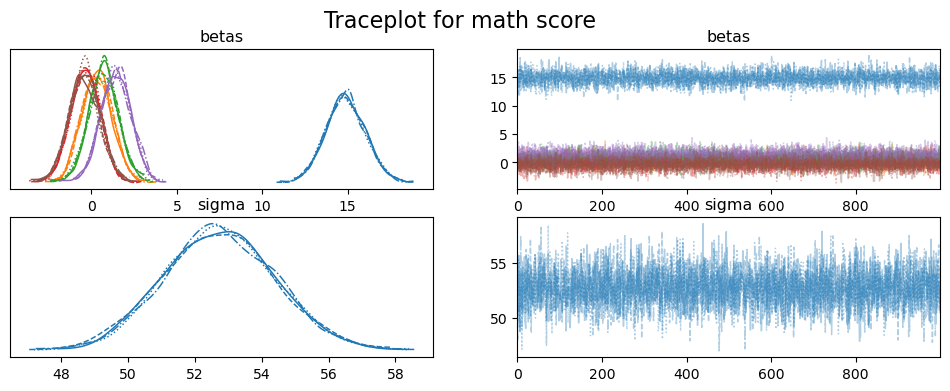

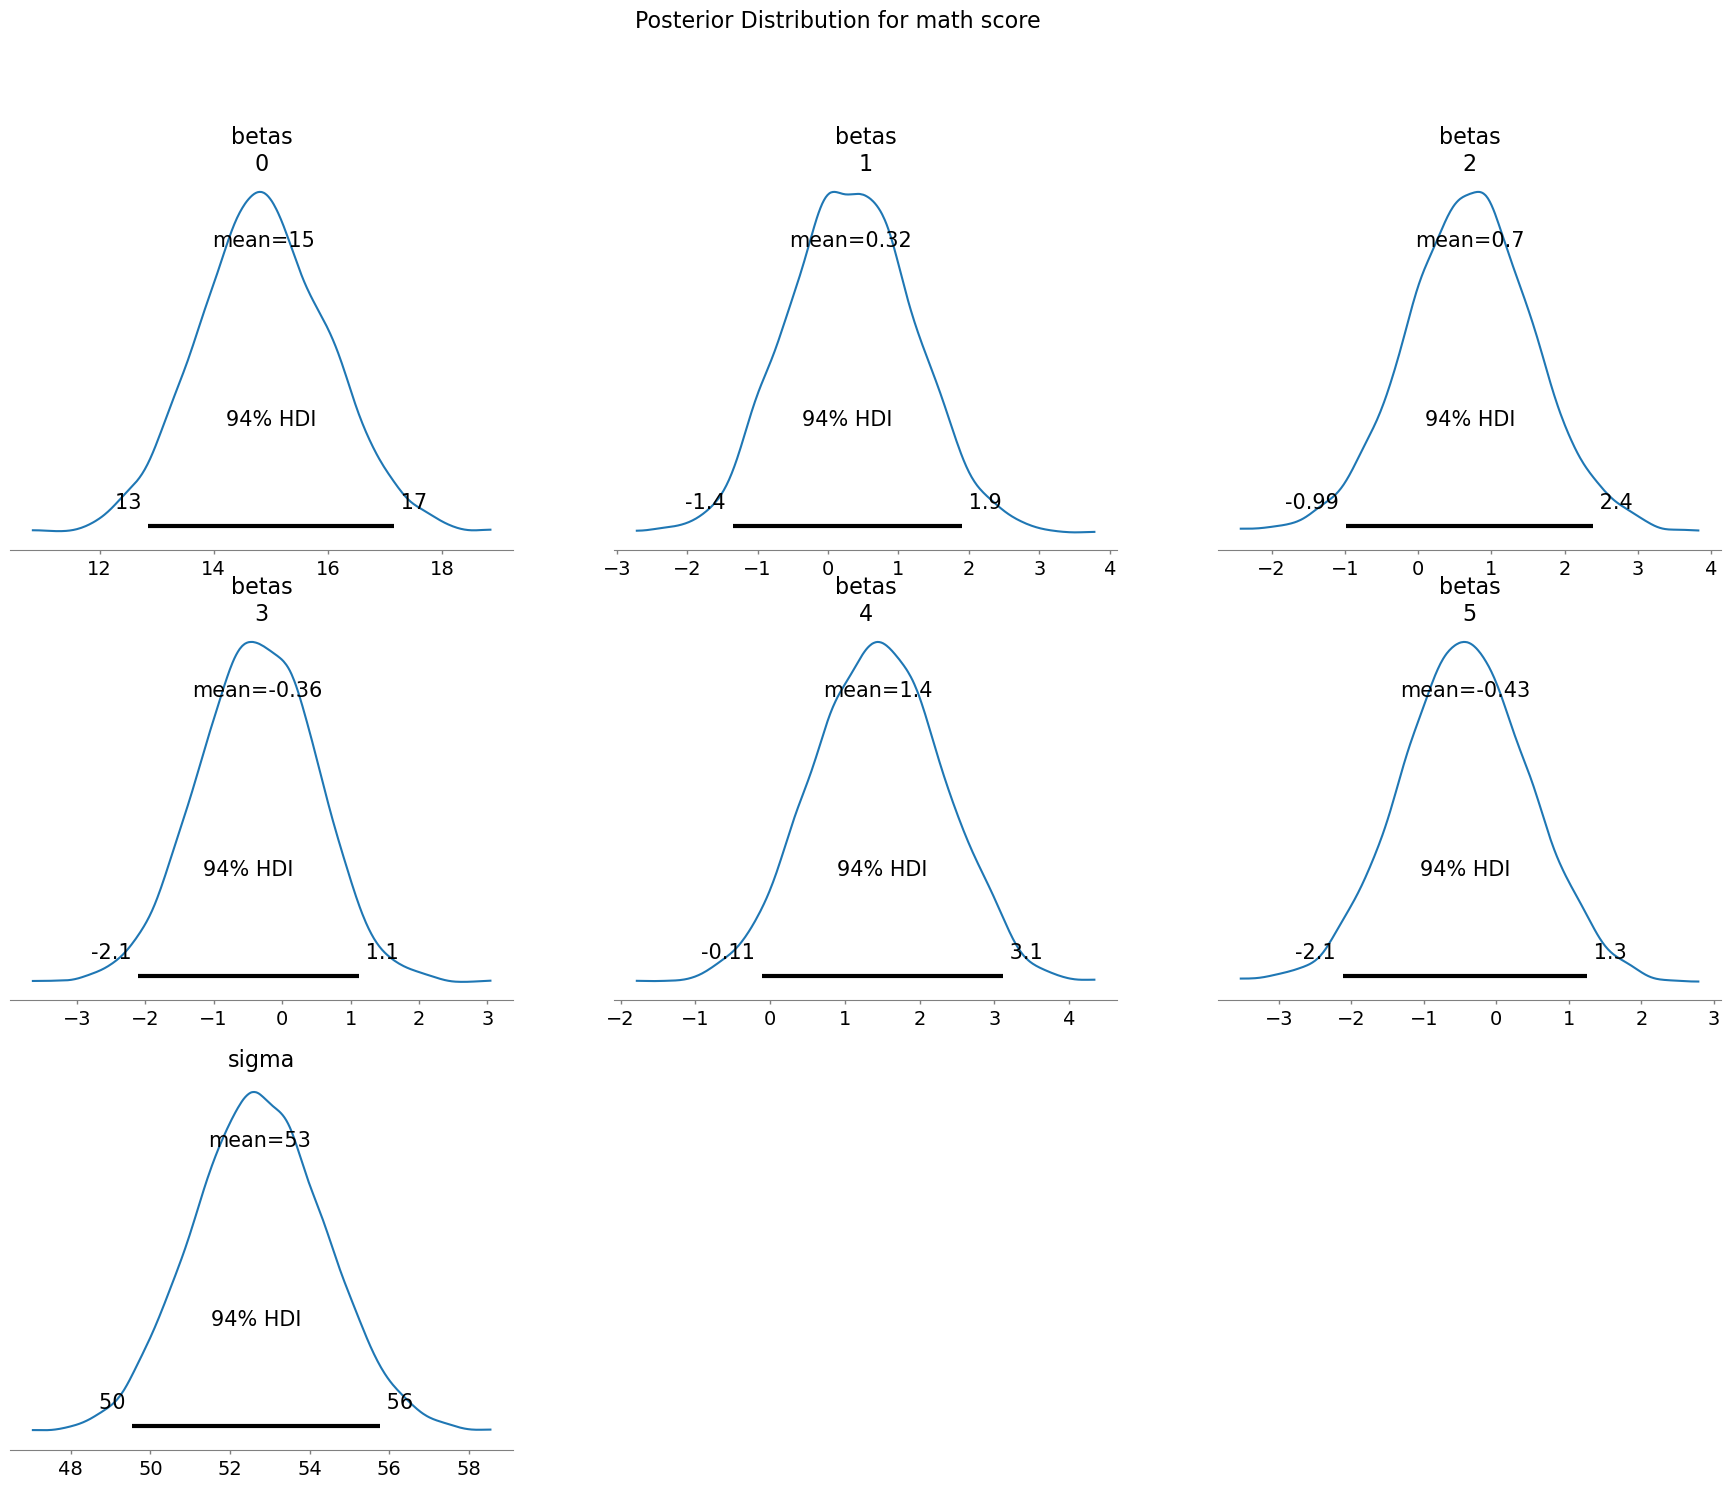

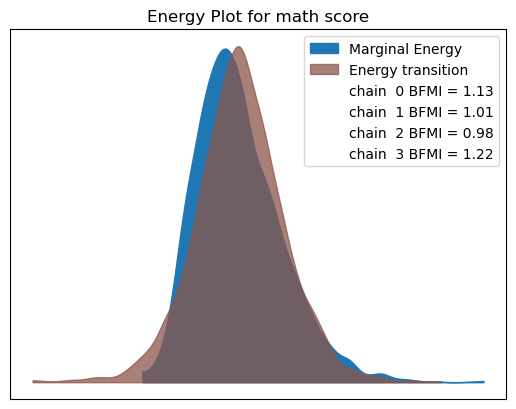

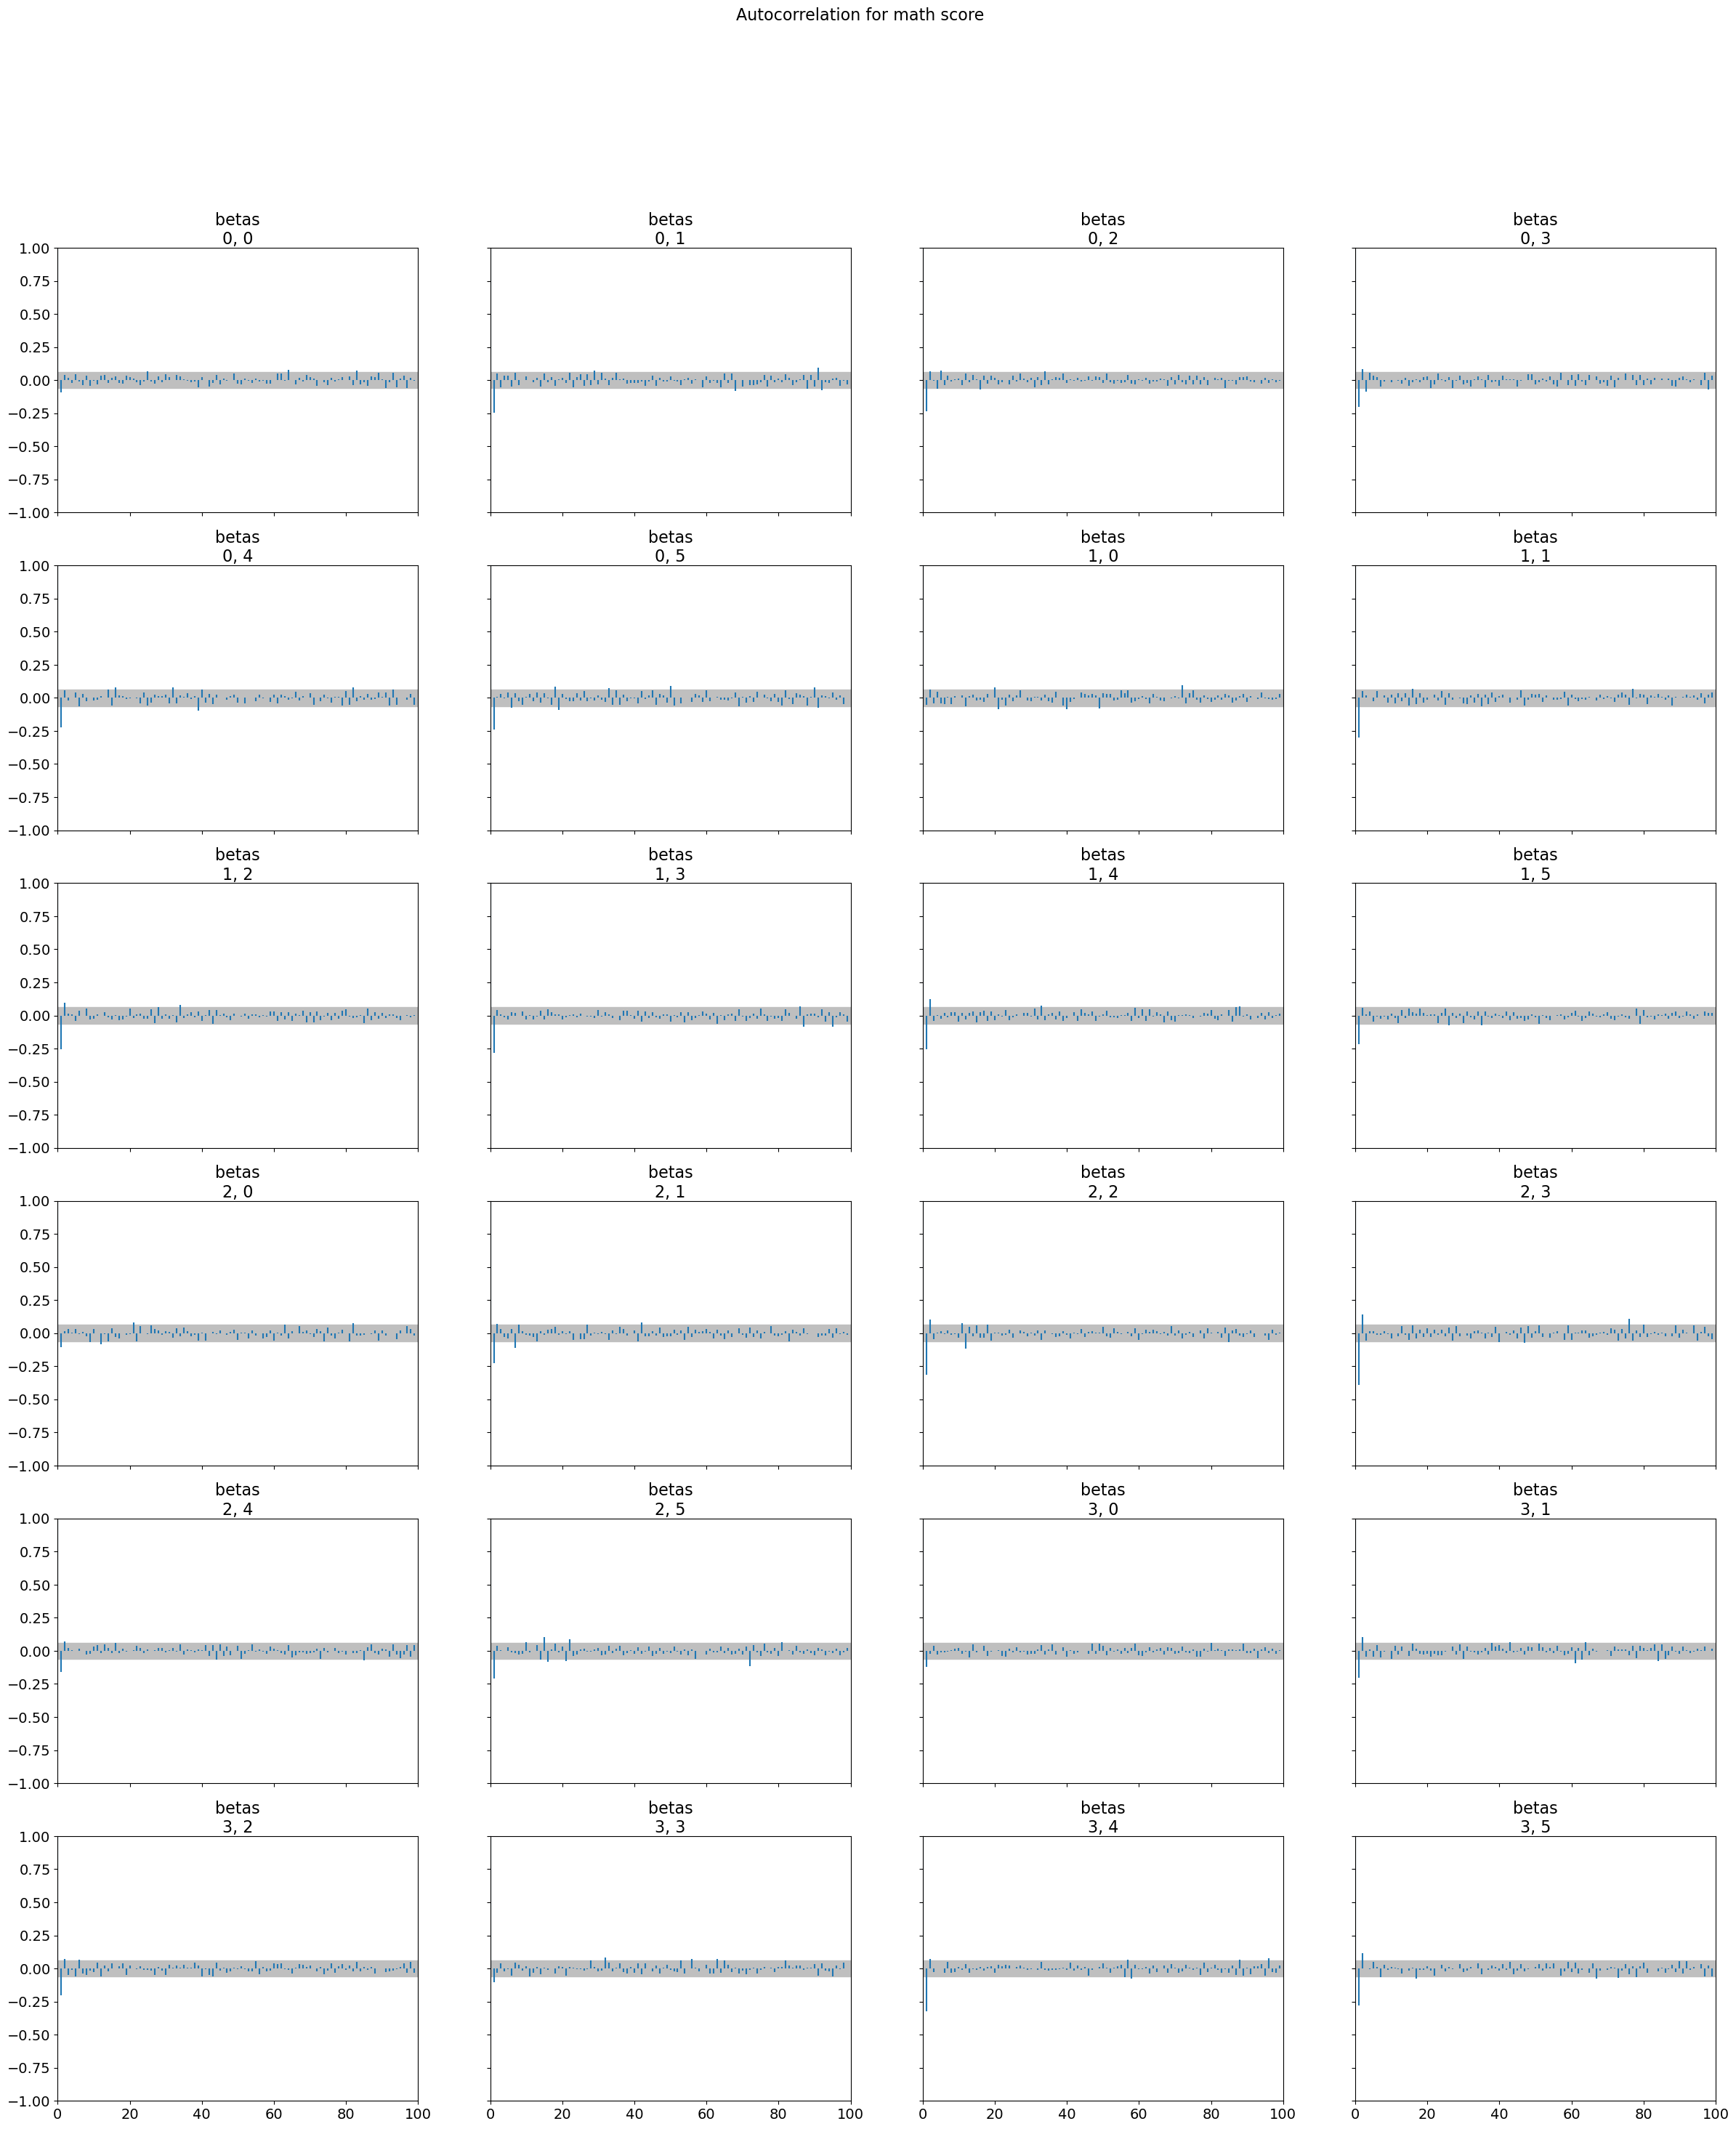

Summary for math score:
           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]  14.87  1.15   12.84    17.17       0.02     0.02   4499.46   
betas[1]   0.32  0.89   -1.36     1.90       0.01     0.02   6421.00   
betas[2]   0.70  0.89   -0.99     2.39       0.01     0.02   6594.67   
betas[3]  -0.36  0.87   -2.10     1.12       0.01     0.02   6946.01   
betas[4]   1.44  0.87   -0.11     3.11       0.01     0.01   6196.93   
betas[5]  -0.43  0.90   -2.12     1.25       0.01     0.02   5783.33   
sigma     52.74  1.67   49.54    55.76       0.03     0.02   4419.10   

          ess_tail  r_hat  
betas[0]   3384.40    1.0  
betas[1]   2897.19    1.0  
betas[2]   2401.73    1.0  
betas[3]   2894.94    1.0  
betas[4]   3083.59    1.0  
betas[5]   2756.90    1.0  
sigma      3334.30    1.0  
BFMI values: [1.12632864 1.0135049  0.98038226 1.21949231]

----------------------------------------------------------------------



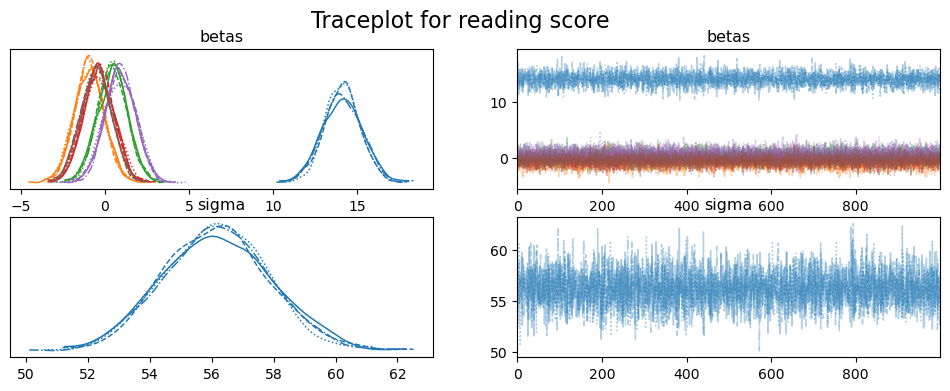

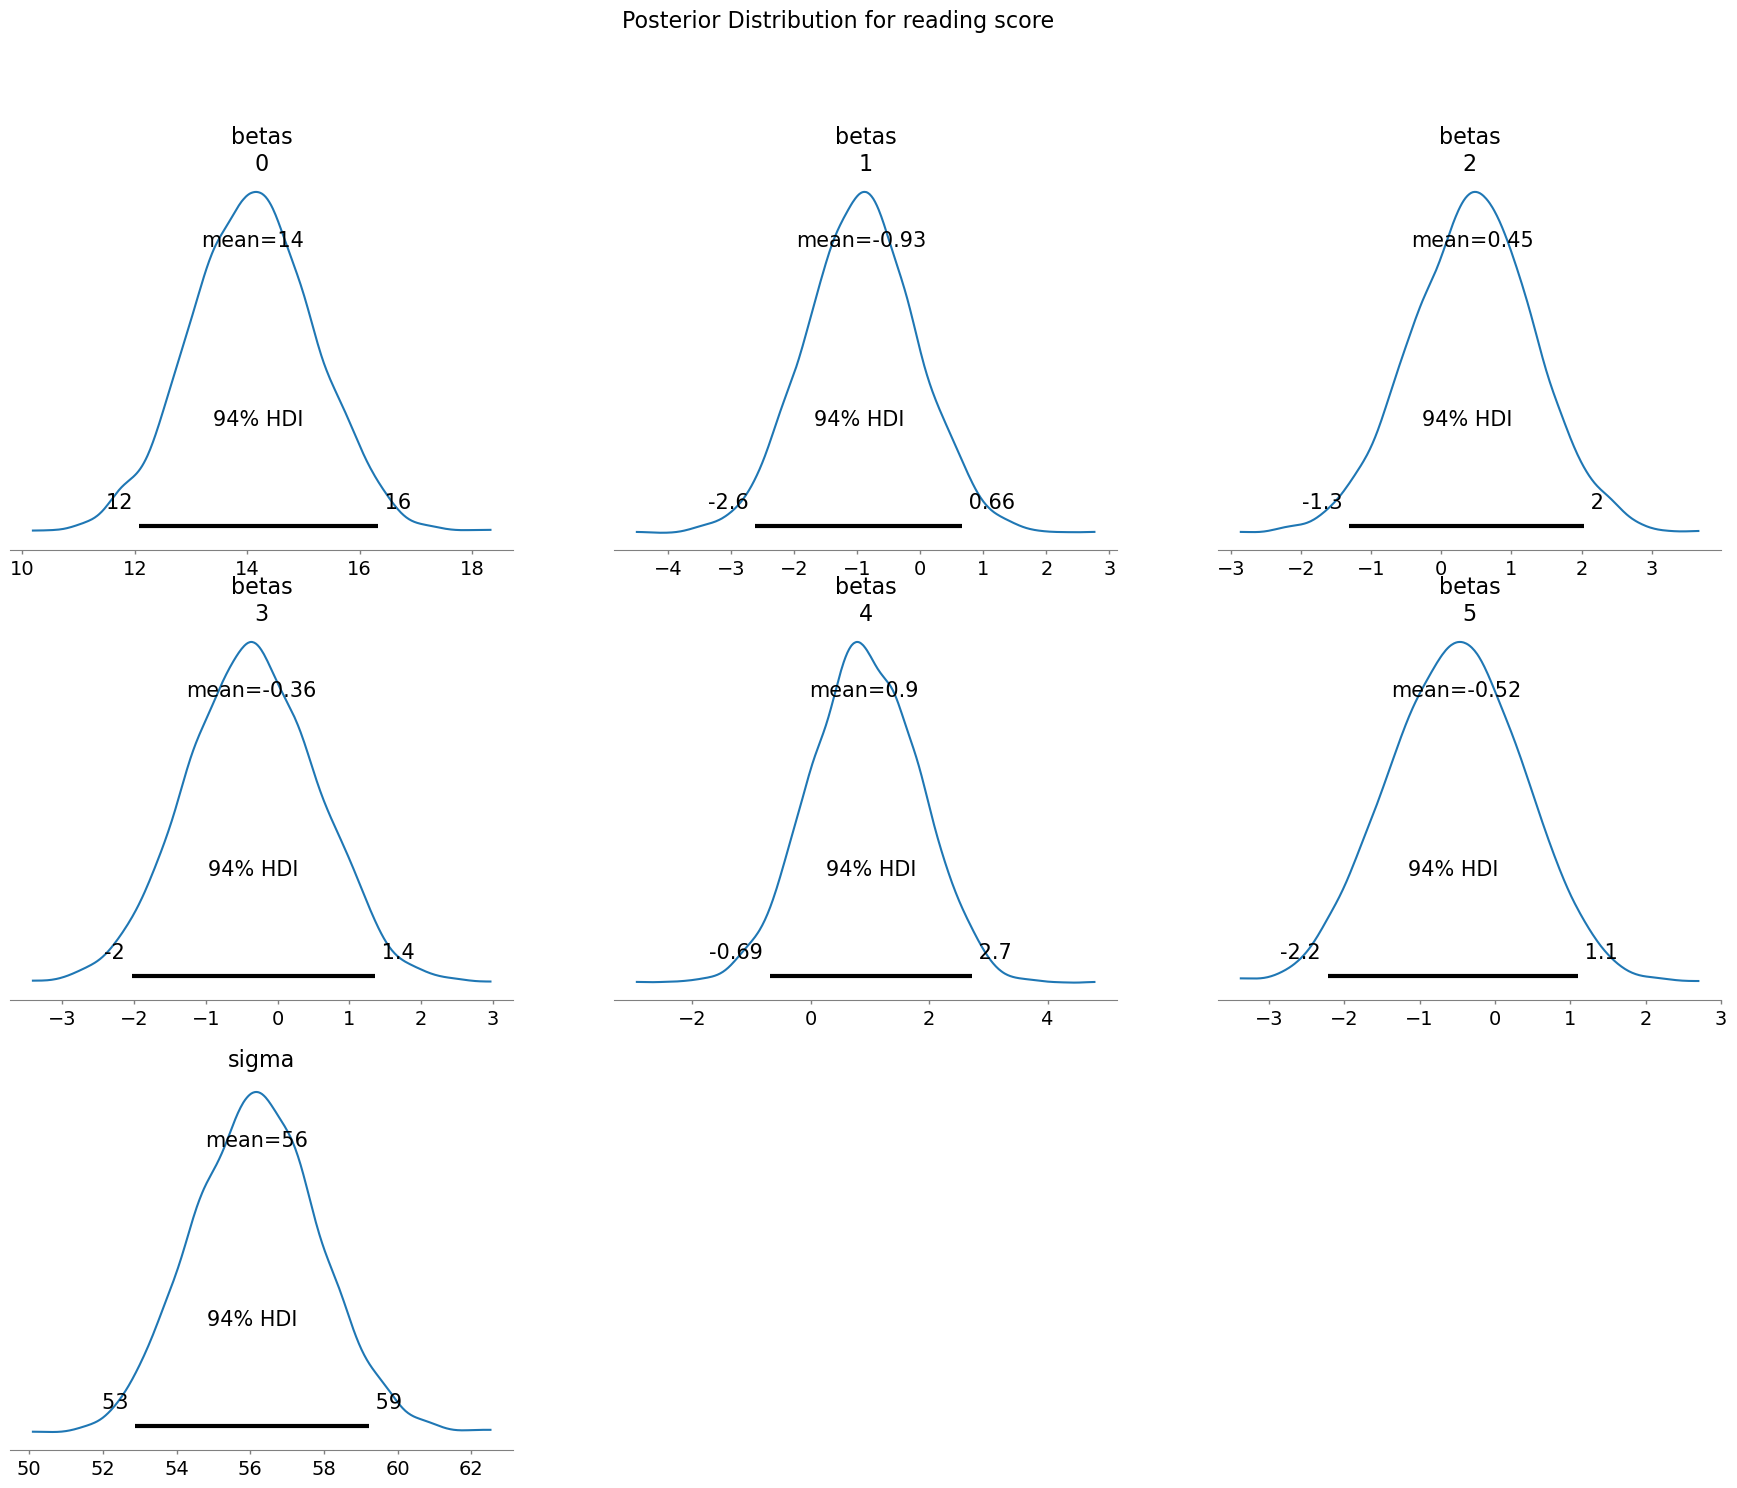

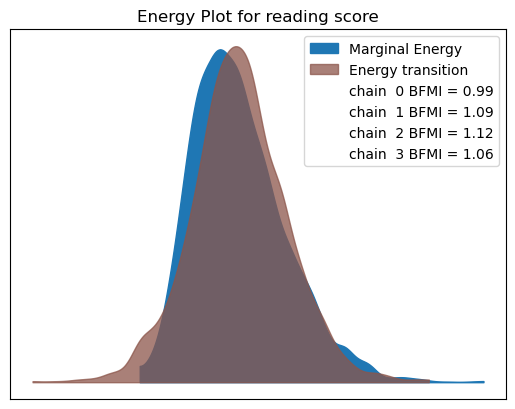

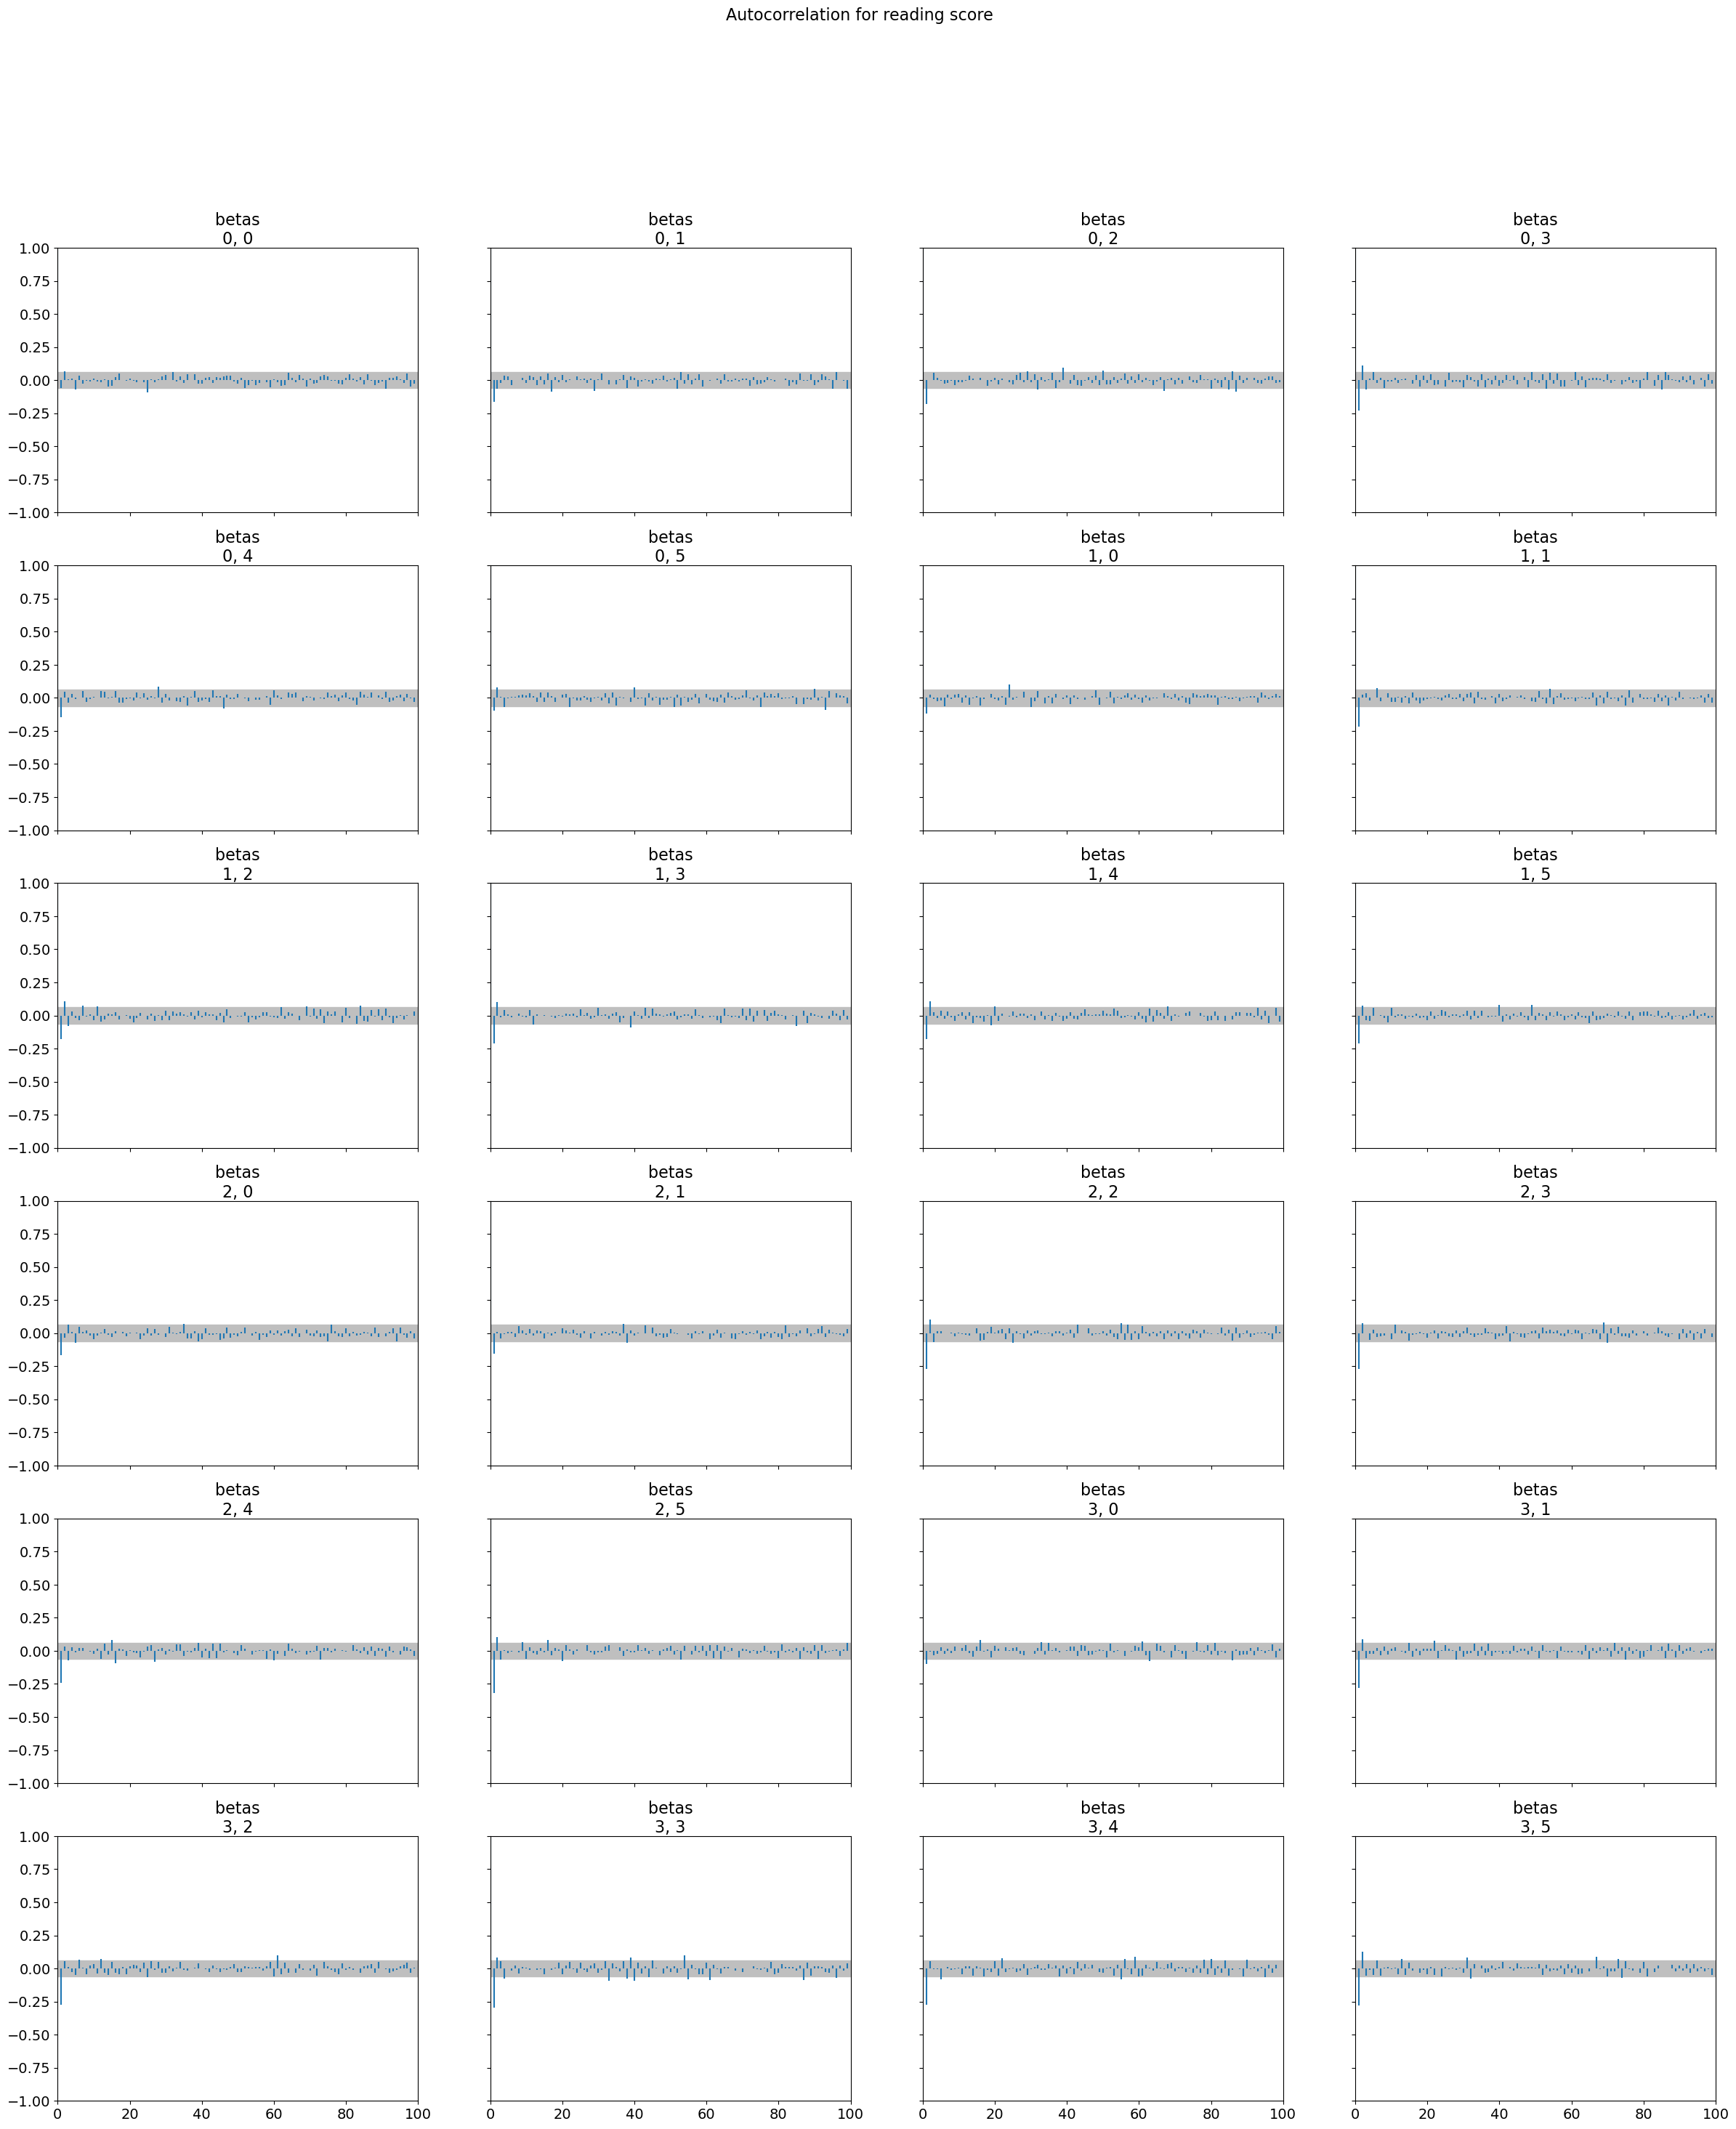

Summary for reading score:
           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]  14.10  1.12   12.08    16.33       0.02     0.02   4877.46   
betas[1]  -0.93  0.88   -2.62     0.66       0.01     0.02   6600.98   
betas[2]   0.45  0.88   -1.31     2.04       0.01     0.02   6284.56   
betas[3]  -0.36  0.91   -2.03     1.35       0.01     0.02   5975.01   
betas[4]   0.90  0.92   -0.69     2.72       0.01     0.02   6033.93   
betas[5]  -0.52  0.89   -2.22     1.10       0.01     0.01   6115.04   
sigma     56.16  1.71   52.88    59.24       0.02     0.03   5210.25   

          ess_tail  r_hat  
betas[0]   3648.45    1.0  
betas[1]   3144.20    1.0  
betas[2]   3198.44    1.0  
betas[3]   2768.28    1.0  
betas[4]   2435.12    1.0  
betas[5]   3153.94    1.0  
sigma      3438.67    1.0  
BFMI values: [0.99017323 1.08652955 1.11534699 1.06299325]

----------------------------------------------------------------------



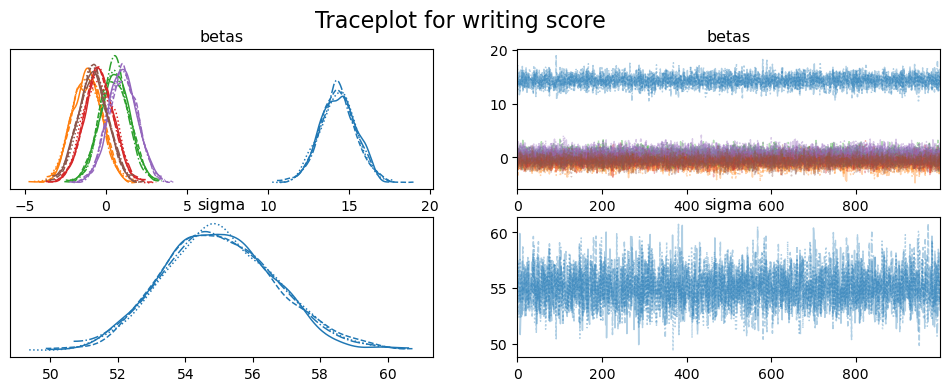

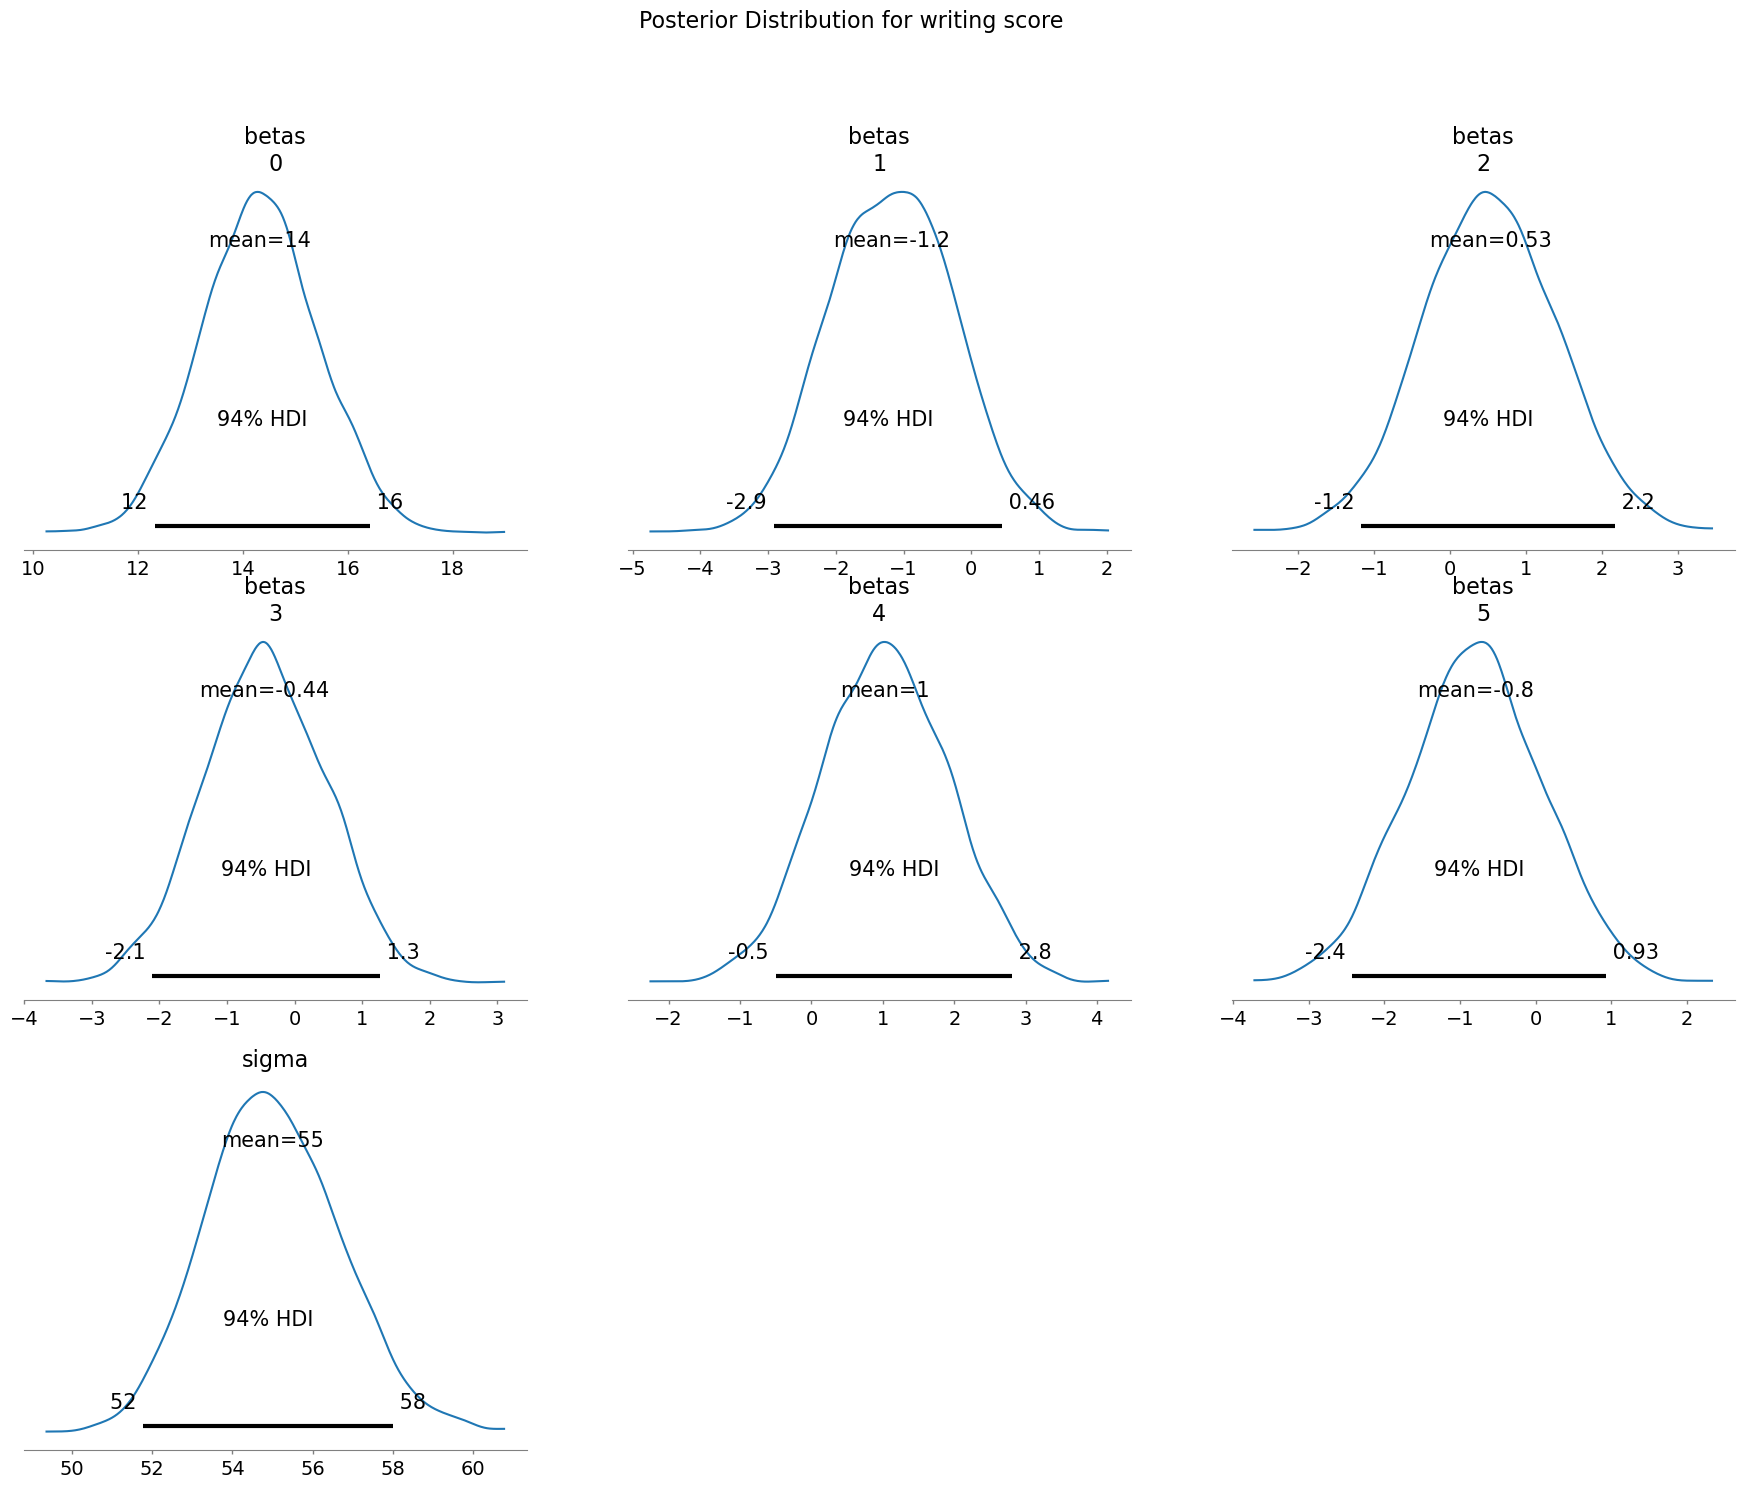

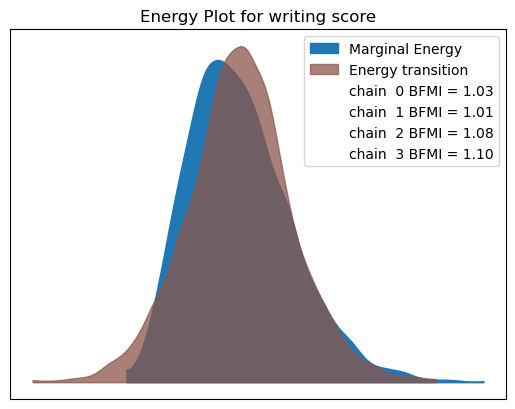

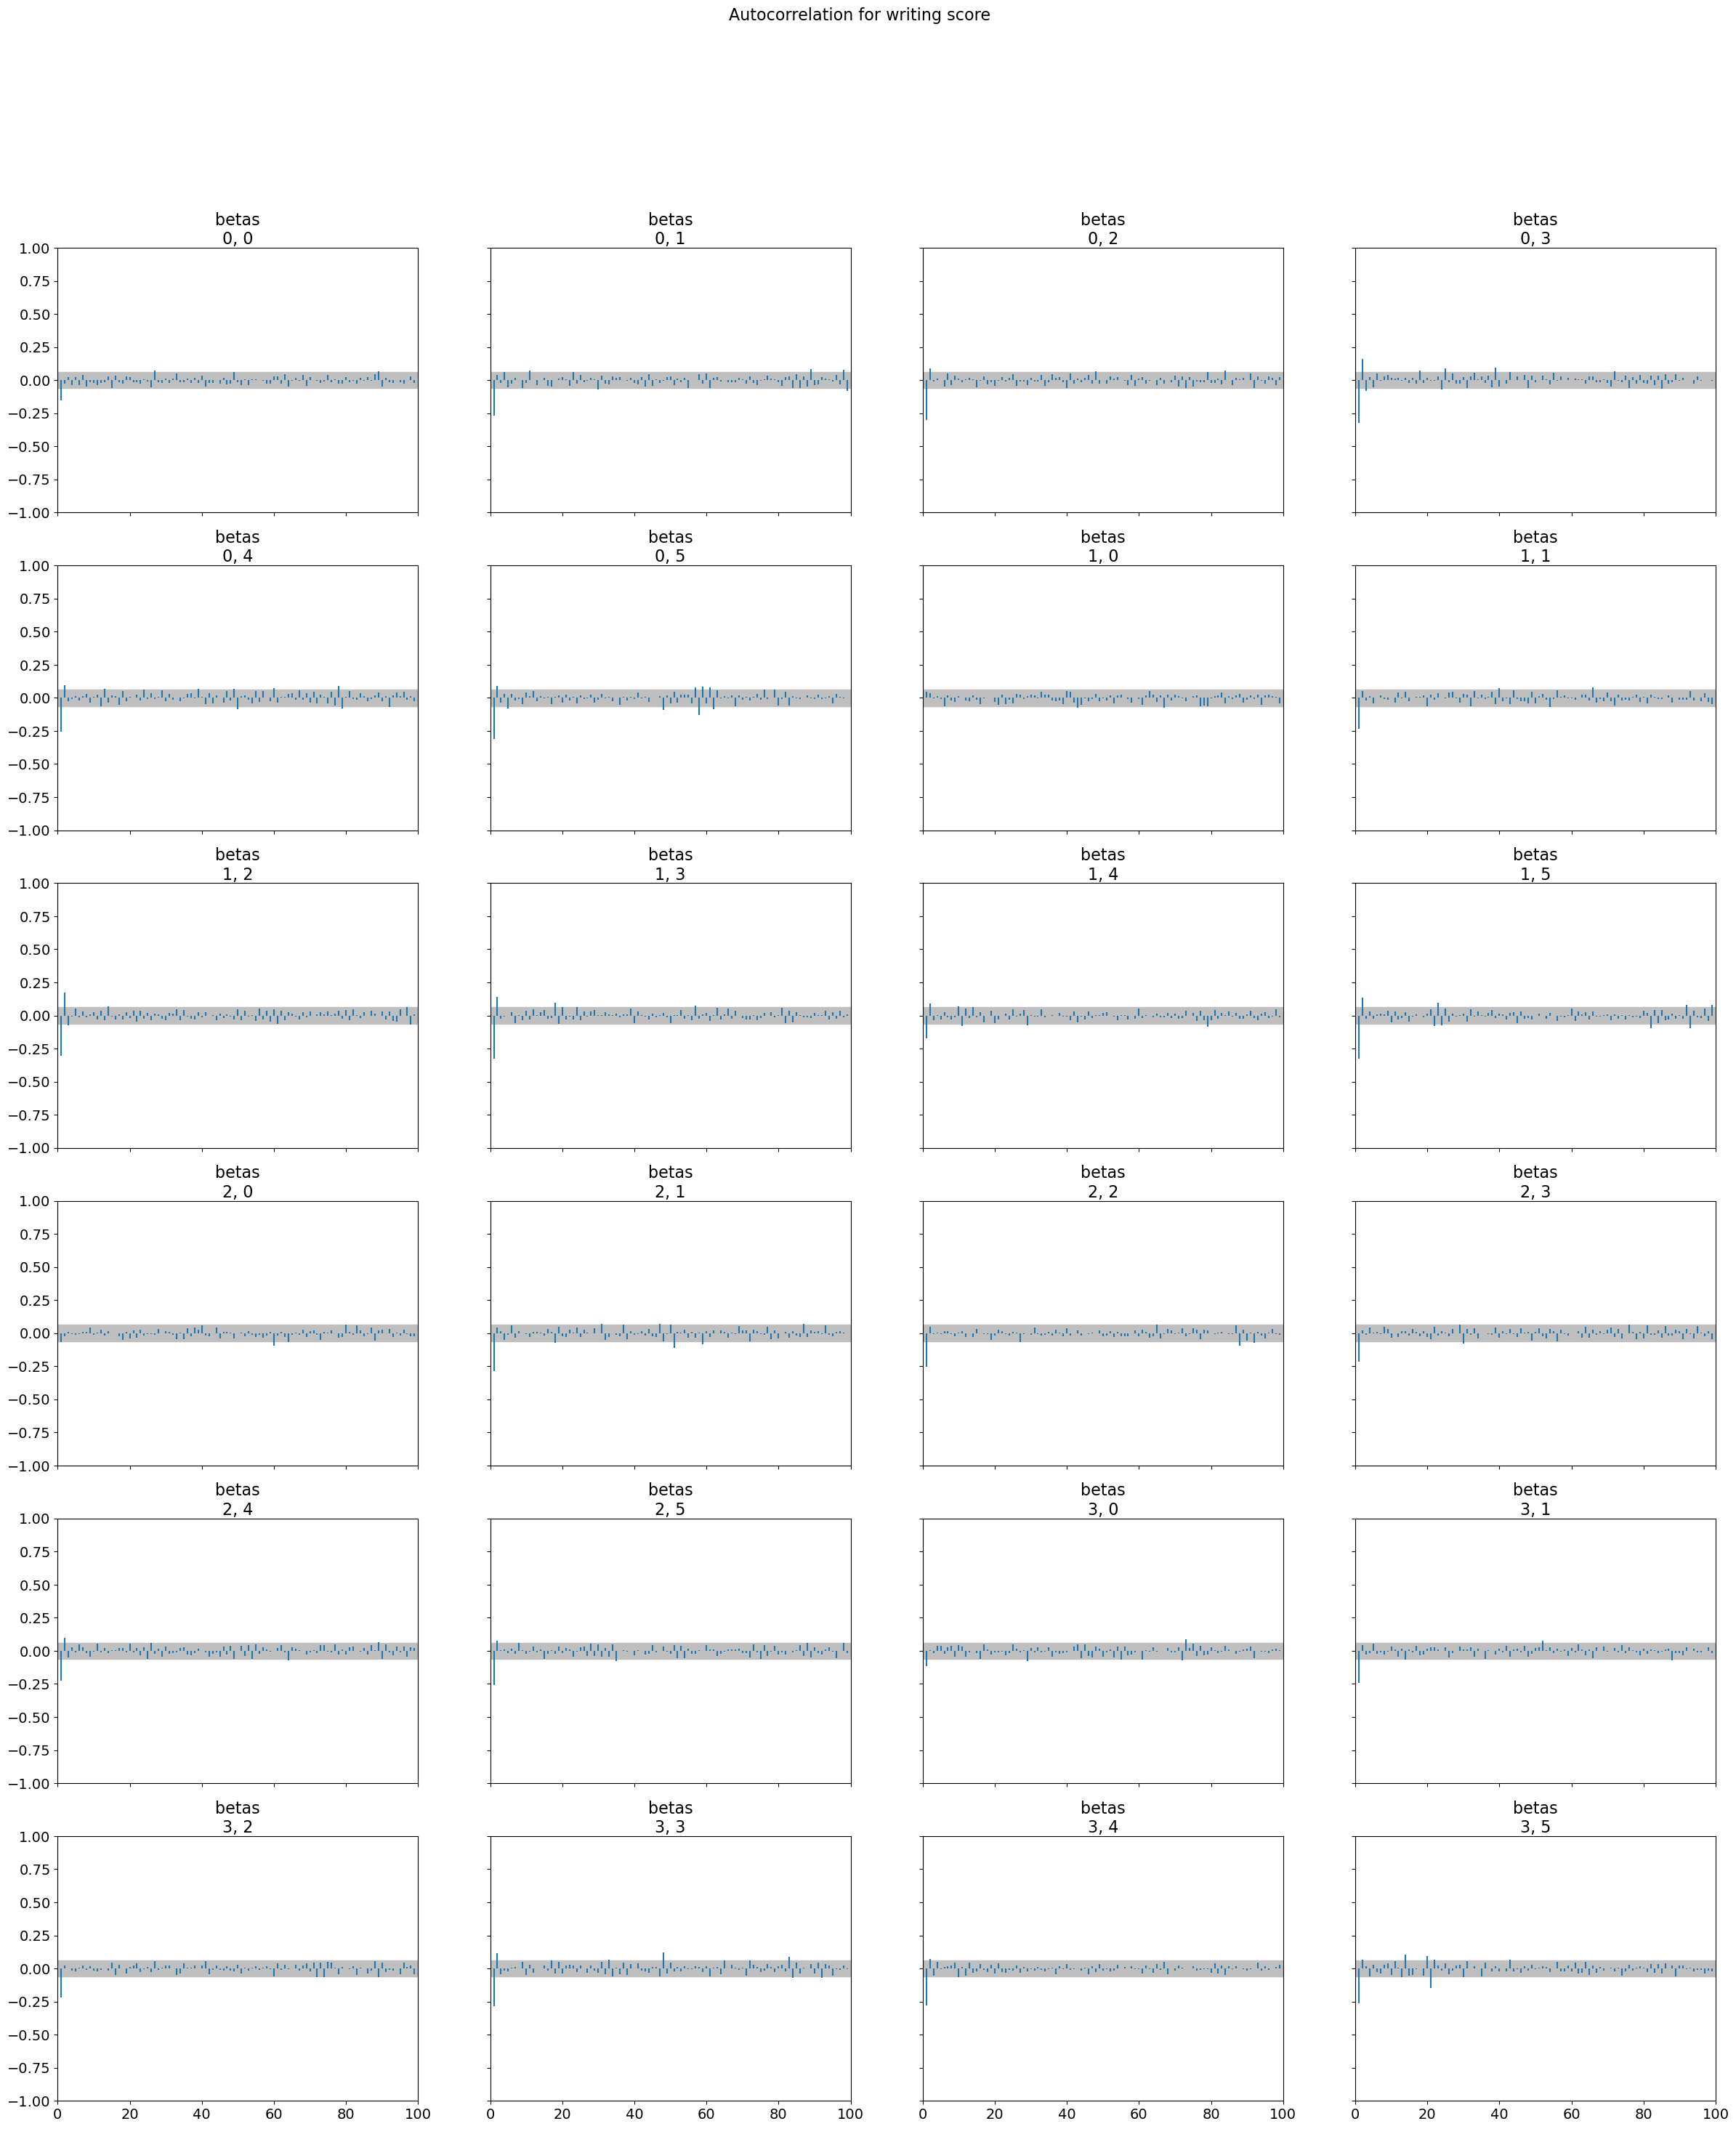

Summary for writing score:
           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]  14.32  1.11   12.32    16.43       0.02     0.02   4651.29   
betas[1]  -1.18  0.92   -2.92     0.46       0.01     0.02   7276.50   
betas[2]   0.53  0.89   -1.17     2.17       0.01     0.01   6942.36   
betas[3]  -0.44  0.90   -2.11     1.27       0.01     0.02   7097.98   
betas[4]   1.02  0.89   -0.50     2.81       0.01     0.01   6213.44   
betas[5]  -0.80  0.90   -2.43     0.93       0.01     0.02   6903.60   
sigma     55.01  1.68   51.77    57.99       0.02     0.02   4604.01   

          ess_tail  r_hat  
betas[0]   3097.42    1.0  
betas[1]   3039.56    1.0  
betas[2]   3029.18    1.0  
betas[3]   3111.00    1.0  
betas[4]   2836.76    1.0  
betas[5]   2819.32    1.0  
sigma      3243.34    1.0  
BFMI values: [1.02953086 1.00797438 1.08277947 1.10018204]

----------------------------------------------------------------------



In [19]:
## Q2 Model1: contstruct models separately
## dataset: https://www.kaggle.com/datasets/spscientist/students-performance-in-exams?resource=download
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load and preprocess dataset
df = pd.read_csv("StudentsPerformance.csv")
feature_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
target_cols = ['math score', 'reading score', 'writing score']

# Encode categorical features
df_encoded = df.copy()
for col in feature_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

X = df_encoded[feature_cols].values
Y = df_encoded[target_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Add intercept
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
n, p = X_train.shape
m = Y_train.shape[1]

# Store traces
traces = {}

# Loop over each target dimension
for i, target in enumerate(target_cols):
    y_train = Y_train[:, i]
    
    with pm.Model() as model:
        betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
        sigma = pm.HalfNormal('sigma', sigma=10)
        mu = pm.math.dot(X_train, betas)
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)
        
        trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True, random_seed=42)
        traces[target] = trace

# Posterior visualization and diagnostics
for target, trace in traces.items():
    az.plot_trace(trace, var_names=["betas", "sigma"])
    plt.suptitle(f"Traceplot for {target}", fontsize=16)
    plt.show()
    
    az.plot_posterior(trace, var_names=["betas", "sigma"])
    plt.suptitle(f"Posterior Distribution for {target}", fontsize=16)
    plt.show()

    az.plot_energy(trace)
    plt.title(f"Energy Plot for {target}")
    plt.show()

    az.plot_autocorr(trace, var_names=["betas"])
    plt.suptitle(f"Autocorrelation for {target}", fontsize=16)
    plt.show()

    print(f"Summary for {target}:")
    print(az.summary(trace, var_names=["betas", "sigma"], round_to=2))
    print("BFMI values:", az.bfmi(trace))
    print("\n" + "-"*70 + "\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 428 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (120) in plot_autocorr, generating only 40 plots
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  0.152  0.030   0.094    0.207      0.001    0.000    3316.0   
betas[0, 1] -0.259  0.031  -0.318   -0.203      0.001    0.000    3278.0   
betas[0, 2] -0.315  0.029  -0.369   -0.261      0.000    0.000    3298.0   
betas[1, 0]  0.188  0.031   0.130    0.247      0.001    0.000    3120.0   
betas[1, 1]  0.122  0.032   0.061    0.180      0.001    0.001    3164.0   
betas[1, 2]  0.135  0.030   0.077    0.188      0.001    0.000    3167.0   
betas[2, 0] -0.050  0.030  -0.106    0.007      0.000    0.000    3909.0   
betas[2, 1] -0.062  0.031  -0.122   -0.006      0.000    0.000    3886.0   
betas[2, 2] -0.080  0.029  -0.134   -0.024      0.000    0.000    3838.0   
betas[3, 0]  0.361  0.030   0.304    0.417      0.001    0.000    3632.0   
betas[3, 1]  0.241  0.031   0.185    0.300      0.001    0.000    3744.0   
betas[3, 2]  0.267  0.029   0.214    0.321      0.000    0.000    3628.0   
betas[4, 0] -0.199  0.030  -0.257   -0.143      0.000    0.000    3661.0   
betas[4, 1] -0.258  0.031  -0.317   -0.199      0.001    0.000    3696.0   
betas[4, 2] -0.328  0.029  -0.380   -0.269      0.000    0.000    3752.0   
Sigma[0, 0]  0.762  0.038   0.693    0.835      0.001    0.001    3533.0   
Sigma[0, 1]  0.683  0.037   0.616    0.751      0.001    0.001    3405.0   
Sigma[0, 2]  0.653  0.035   0.592    0.720      0.001    0.001    3471.0   
Sigma[1, 0]  0.683  0.037   0.616    0.751      0.001    0.001    3405.0   
Sigma[1, 1]  0.786  0.040   0.709    0.857      0.001    0.001    3548.0   
Sigma[1, 2]  0.700  0.036   0.635    0.771      0.001    0.001    3484.0   
Sigma[2, 0]  0.653  0.035   0.592    0.720      0.001    0.001    3471.0   
Sigma[2, 1]  0.700  0.036   0.635    0.771      0.001    0.001    3484.0   
Sigma[2, 2]  0.694  0.035   0.630    0.760      0.001    0.001    3543.0   

             ess_tail  r_hat  
betas[0, 0]    3015.0    1.0  
betas[0, 1]    3048.0    1.0  
betas[0, 2]    2988.0    1.0  
betas[1, 0]    2629.0    1.0  
betas[1, 1]    2753.0    1.0  
betas[1, 2]    2590.0    1.0  
betas[2, 0]    3010.0    1.0  
betas[2, 1]    2746.0    1.0  
betas[2, 2]    2901.0    1.0  
betas[3, 0]    3158.0    1.0  
betas[3, 1]    3103.0    1.0  
betas[3, 2]    3036.0    1.0  
betas[4, 0]    3057.0    1.0  
betas[4, 1]    3193.0    1.0  
betas[4, 2]    3009.0    1.0  
Sigma[0, 0]    3296.0    1.0  
Sigma[0, 1]    3006.0    1.0  
Sigma[0, 2]    2793.0    1.0  
Sigma[1, 0]    3006.0    1.0  
Sigma[1, 1]    2881.0    1.0  
Sigma[1, 2]    2782.0    1.0  
Sigma[2, 0]    2793.0    1.0  
Sigma[2, 1]    2782.0    1.0  
Sigma[2, 2]    3064.0    1.0

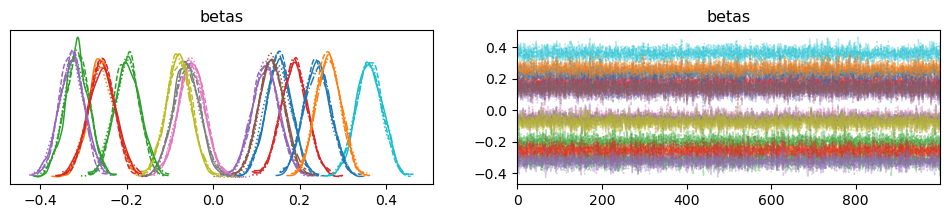

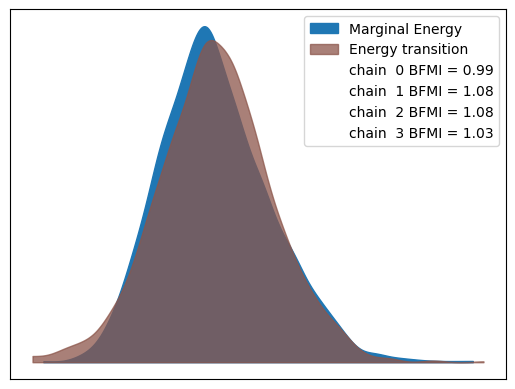

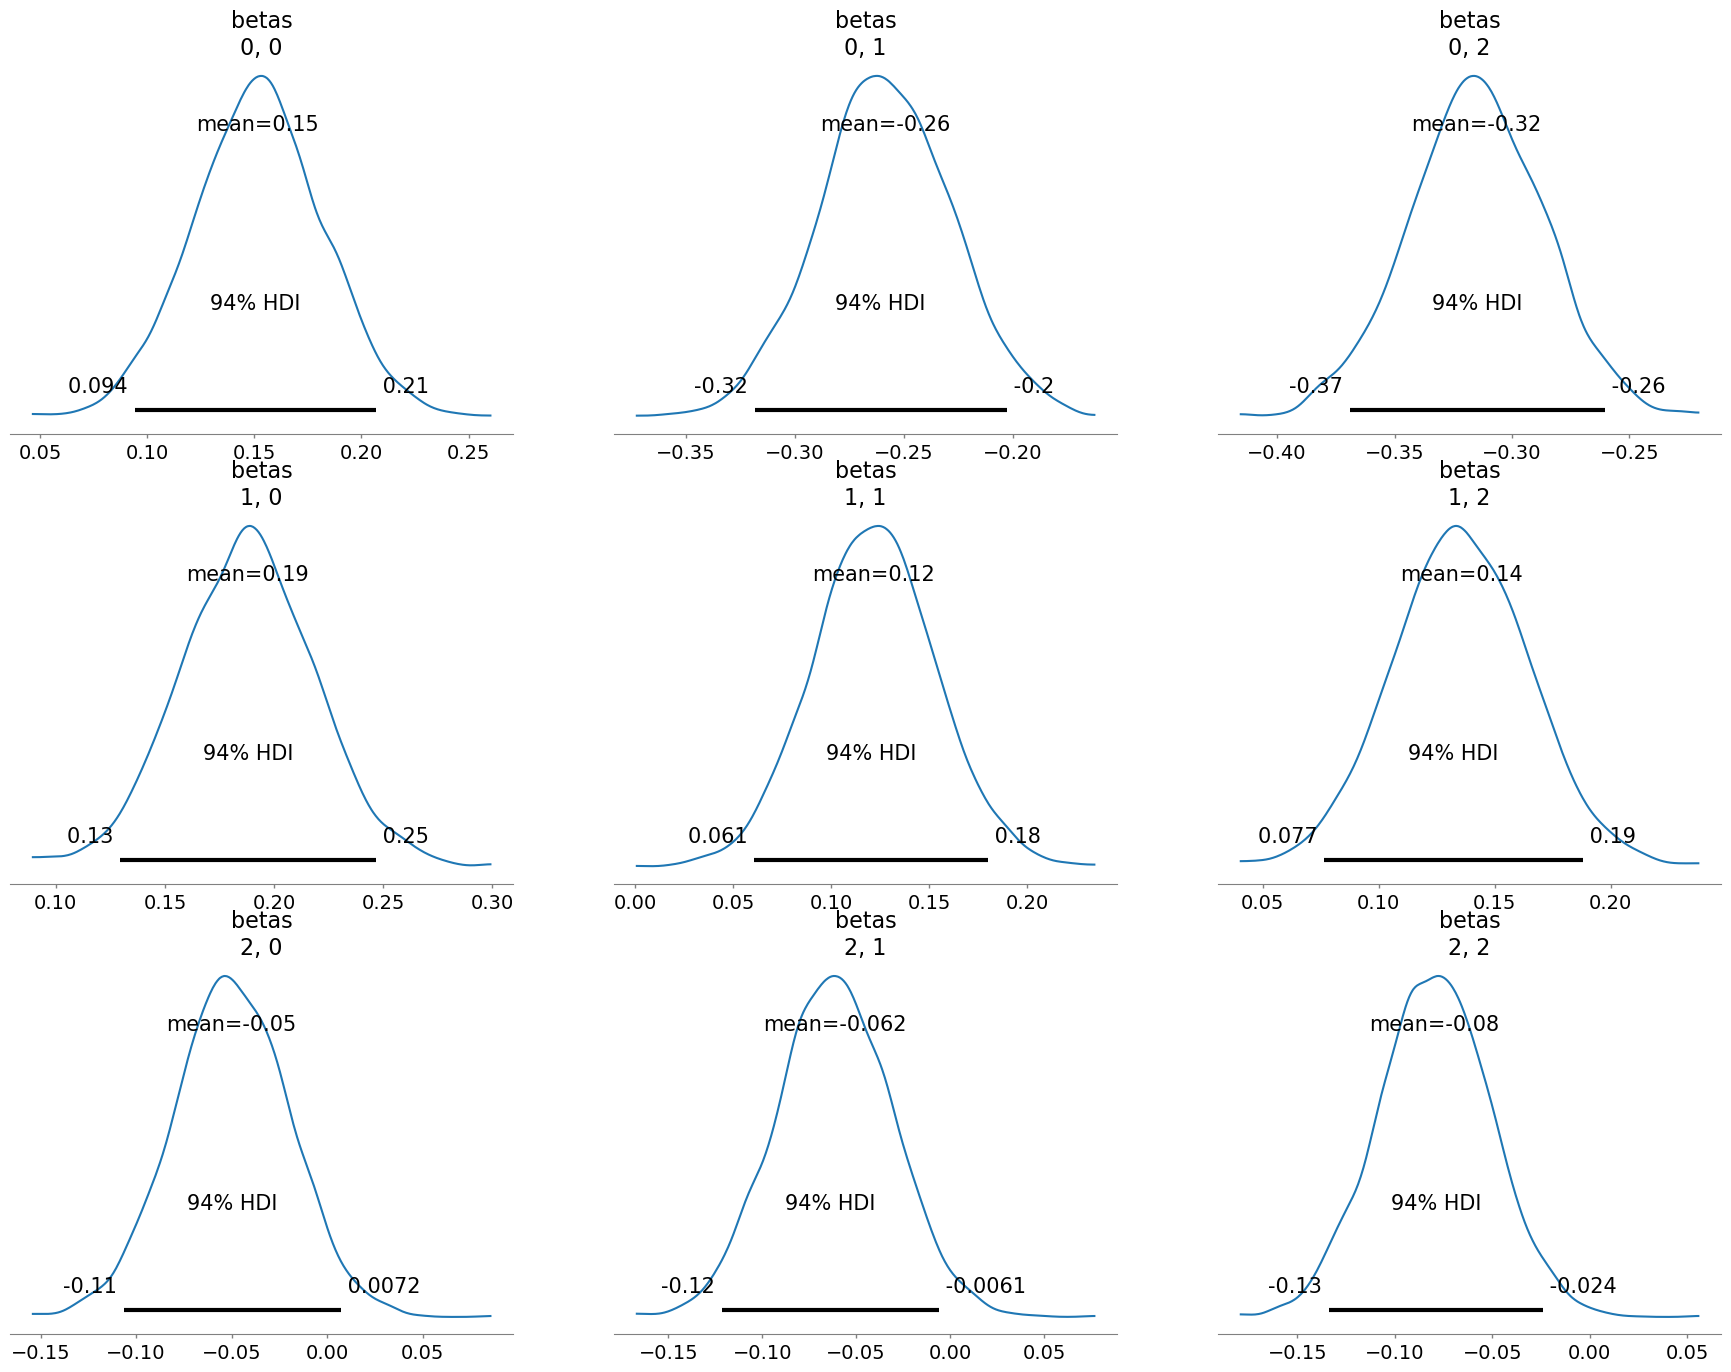

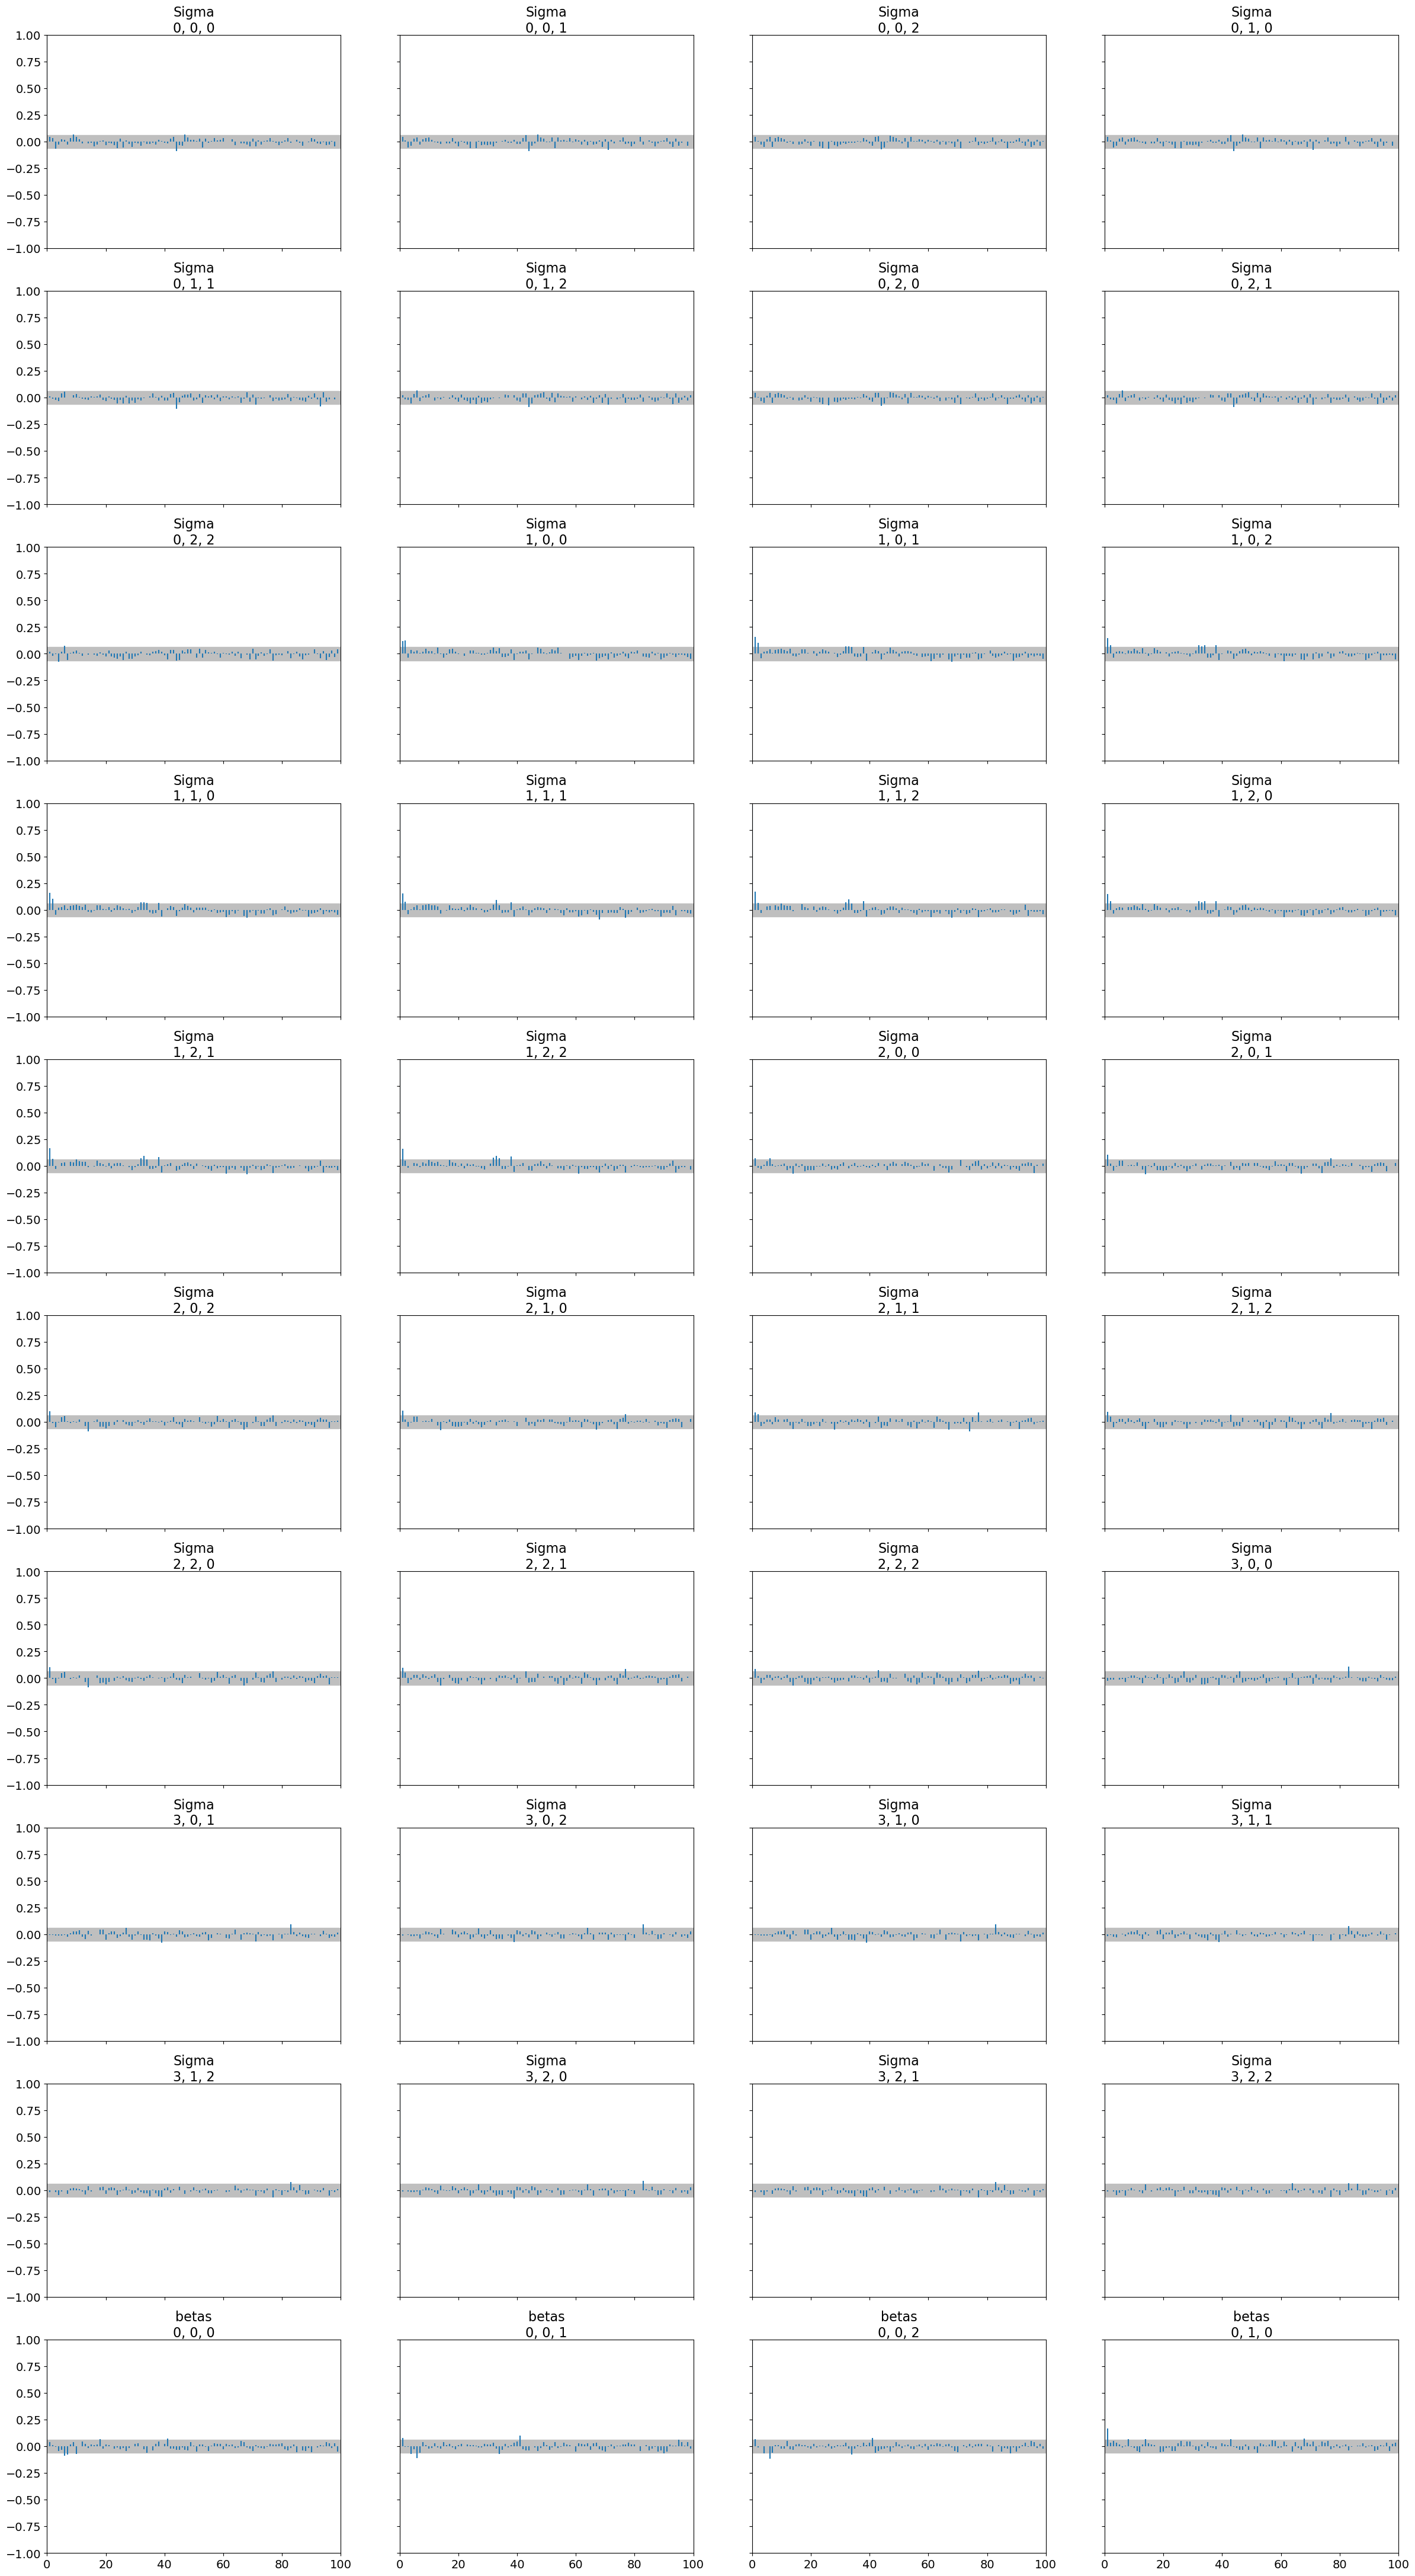

In [5]:
# Q2 model2: combine 3 models
import pandas as pd
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv("StudentsPerformance.csv")

feature_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
target_cols = ['math score', 'reading score', 'writing score']

df_encoded = df.copy()
for col in feature_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

X = df_encoded[feature_cols].values
Y = df_encoded[target_cols].values

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler_X = StandardScaler().fit(X_train)
scaler_Y = StandardScaler().fit(Y_train)

X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)

n, p = X_train_scaled.shape
m = Y_train_scaled.shape[1]


with pm.Model() as mv_model:
    
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic("Sigma", L @ L.T)

    
    mu = pm.math.dot(X_train_scaled, betas)
    y_obs = pm.MvNormal("y_obs", mu=mu, chol=L, observed=Y_train_scaled)

    # MCMC
    idata_mv = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True, random_seed=42)



az.plot_trace(idata_mv, var_names=["betas"])
az.plot_energy(idata_mv)
az.plot_posterior(idata_mv, var_names=["betas"], coords={"betas_dim_0": [0, 1, 2], "betas_dim_1": [0, 1, 2]})
az.plot_autocorr(idata_mv)
az.summary(idata_mv, var_names=["betas", "Sigma"])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 274 seconds.


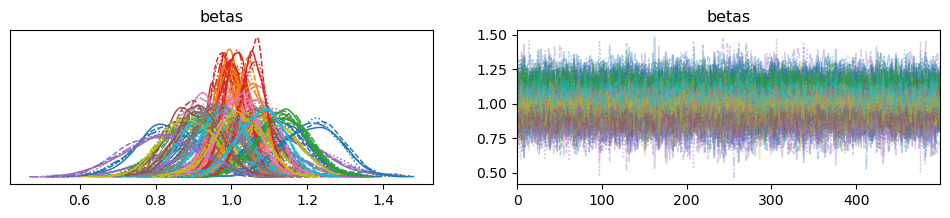

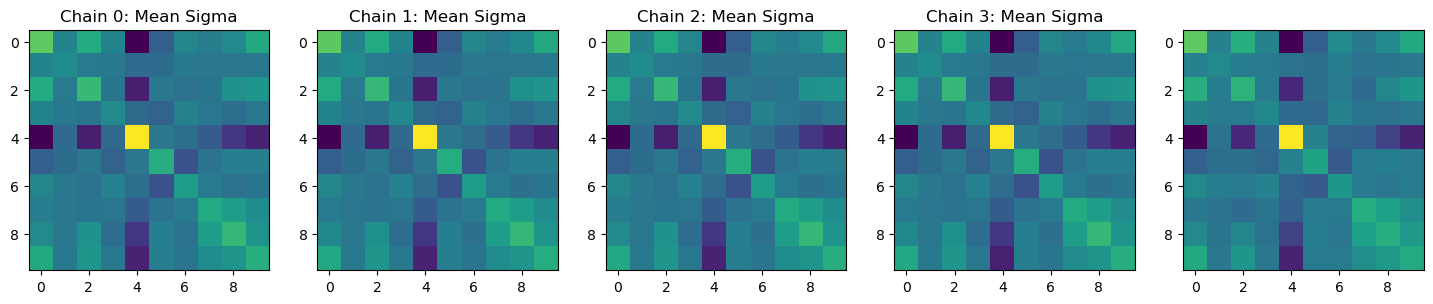

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  1.10  0.09    0.94     1.27        0.0      0.0   1183.12   
betas[0, 1]  1.02  0.04    0.93     1.09        0.0      0.0   2392.24   
betas[0, 2]  1.04  0.08    0.90     1.18        0.0      0.0   1460.75   
betas[0, 3]  1.00  0.04    0.93     1.07        0.0      0.0   1699.69   
betas[0, 4]  0.93  0.12    0.71     1.14        0.0      0.0   1105.22   
...           ...   ...     ...      ...        ...      ...       ...   
Sigma[9, 5]  0.06  0.04   -0.00     0.13        0.0      0.0   1881.39   
Sigma[9, 6] -0.00  0.03   -0.06     0.05        0.0      0.0   1824.07   
Sigma[9, 7]  0.17  0.04    0.09     0.24        0.0      0.0   1743.71   
Sigma[9, 8]  0.23  0.04    0.15     0.31        0.0      0.0   1570.90   
Sigma[9, 9]  0.42  0.05    0.32     0.52        0.0      0.0   1294.15   

             ess_tail  r_hat  
betas[0, 0]   1244.47    1.0  
betas[0, 1]   1466.58    1.0  
betas[0, 2]   1542.65    1.0  
betas[0, 3]   1572.62    1.0  
betas[0, 4]   1289.96    1.0  
...               ...    ...  
Sigma[9, 5]   1705.94    1.0  
Sigma[9, 6]   1573.00    1.0  
Sigma[9, 7]   1514.43    1.0  
Sigma[9, 8]   1557.74    1.0  
Sigma[9, 9]   1539.03    1.0  

[150 rows x 9 columns]

In [6]:
#### import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

# Covariance Matrix Estimation with LKJ Prior
n, m, p = 100, 10, 5
beta_ = np.ones((p, m))  # True regression coefficients
X = stats.norm().rvs((n, p))  # Data matrix
a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()  # True covariance matrix
x = X @ beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)  # Generated observations


with pm.Model() as MNV_LKJ:
    # LKJ Cholesky Covariance prior
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)  # Expand the packed triangular matrix
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))  # Regression coefficients prior
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Covariance matrix (Sigma)
    
    # Multivariate Normal likelihood
    y = pm.MvNormal('y', mu=X @ betas, chol=L, observed=x)

    
    idata = pm.sample(500, tune=500, target_accept=0.9, return_inferencedata=True, random_seed=42)

# Traceplot for betas
az.plot_trace(idata, var_names='betas')
plt.show()


fig, ax = plt.subplots(1, 5, figsize=(18, 4))
ax[-1].imshow(a_cov)
ax[0].set_title("Sigma used to generate y")

for chain in range(4):  # Assume 4 chains are sampled
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])  # Mean Sigma for each chain
    ax[chain].set_title(f"Chain {chain}: Mean Sigma")

plt.show()

summaries = az.summary(idata, var_names=["betas", "Sigma"], round_to=2)
summaries


## Interpretation of Results
## Bayesian  Multivariate Analysis on Student Performance Dataset
### 1. Posterior Distributions & Trace Plots
* Trace Plots: The trace plots show the posterior distributions of the regression coefficients (betas). The curves represent the estimated probability density of these coefficients. The left plot illustrates how the coefficients are sampled across iterations.

* Chain Mixing: The right plot (trace plot for sampled values) demonstrates that all chains are well-mixed, meaning the Markov Chains have adequately explored the parameter space.

* Conclusion: There is no sign of divergence or multimodality in the trace plots, which indicates that the model has stable and well-converged parameter estimates.

### 2. Energy Plot and Bayesian Fraction of Missing Information (BFMI)
* Energy Plot: The energy plot compares the marginal energy (blue) with the energy transition (brown). It shows that the model is efficiently exploring the parameter space without any major issues.

* Bayesian Fraction of Missing Information (BFMI): The BFMI values for the chains are close to 1 (e.g., 1.01, 1.08), which is ideal. This suggests that the sampler is effectively exploring the posterior distribution, confirming that our model is not suffering from poor mixing.

* Conclusion: The sampler is working efficiently without issues, and the model does not suffer from poor mixing, which is a positive diagnostic indicator.

### 3. Posterior Summary Statistics
* Posterior Summary Table: The posterior summary provides estimates for the mean, standard deviation, and credible intervals (HDI 3% and HDI 97%) for each parameter. These values are crucial in understanding the uncertainty in our estimates.

* R-hat Values: The R-hat values are all 1.0, confirming that all chains have converged properly. This is a strong indicator of the model's stability and convergence.

* Effective Sample Size (ESS): The ESS values are sufficiently high, suggesting that the model is producing independent samples efficiently, which is a good sign of the model’s sampling efficiency.

* Conclusion: The posterior statistics confirm that our model is well-converged and efficient, producing reliable estimates of the parameters.

### 4. Covariance Structure Estimation (Sigma)
* Heatmaps: The heatmaps represent the posterior mean estimates for the covariance matrix (Sigma). These heatmaps visually depict the relationships between different target variables (math, reading, and writing scores). The consistency across chains suggests that the covariance estimation is stable and reliable.

* LKJ Prior: The use of the LKJ prior has effectively constrained the covariance matrix, allowing for a reasonable estimation of interdependencies between the target variables.

* Conclusion: The covariance structure has been successfully estimated, and the use of the LKJ prior has helped in constraining the model, yielding a stable estimate of the relationships among the target variables.

### 5. Final Conclusion
* Model Convergence: The MCMC diagnostics, including trace plots and energy plots, suggest that the model has converged well. The posterior distributions indicate that the regression coefficients and covariance matrix are estimated with high certainty.

* Fit Quality: The posterior predictive checks (PPC) show that the model fits the observed data well. The predicted distributions for math, reading, and writing scores closely match the observed data, confirming the model’s effectiveness.

* Stability: The posterior distribution of the covariance matrix (Sigma) is stable, and the model successfully captures dependencies between the target variables (math, reading, writing scores).



arviz - WARNING - Shape validation failed: input_shape: (1, 300), minimum_shape: (chains=2, draws=4)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0, 0]  0.001  1.032  -1.754    2.131      0.063    0.044     272.0   
beta[0, 1]  0.053  1.017  -1.588    2.014      0.060    0.040     287.0   
beta[0, 2] -0.030  1.077  -1.909    1.998      0.073    0.052     231.0   
beta[1, 0]  0.007  0.984  -1.620    1.967      0.056    0.039     309.0   
beta[1, 1]  0.061  1.023  -1.638    2.187      0.062    0.046     265.0   
beta[1, 2] -0.092  1.041  -1.956    1.979      0.062    0.038     285.0   
beta[2, 0]  0.120  0.927  -1.365    2.053      0.049    0.039     349.0   
beta[2, 1]  0.043  1.047  -1.572    2.131      0.067    0.042     251.0   
beta[2, 2] -0.072  1.043  -1.796    1.841      0.060    0.039     315.0   
cov[0, 0]   1.000  0.000   1.000    1.000      0.000      NaN     300.0   
cov[0, 1]   0.200  0.000   0.200    0.200      0.000    0.000     300.0   
cov[0, 2]   0.100  0.000   0.100    0.100      0.000    0.000     300.0   
cov[1, 0]   0.200  0.000 

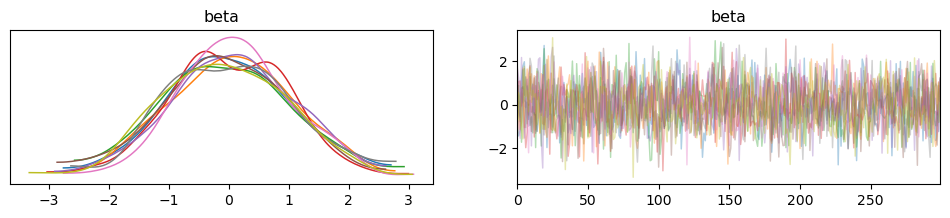

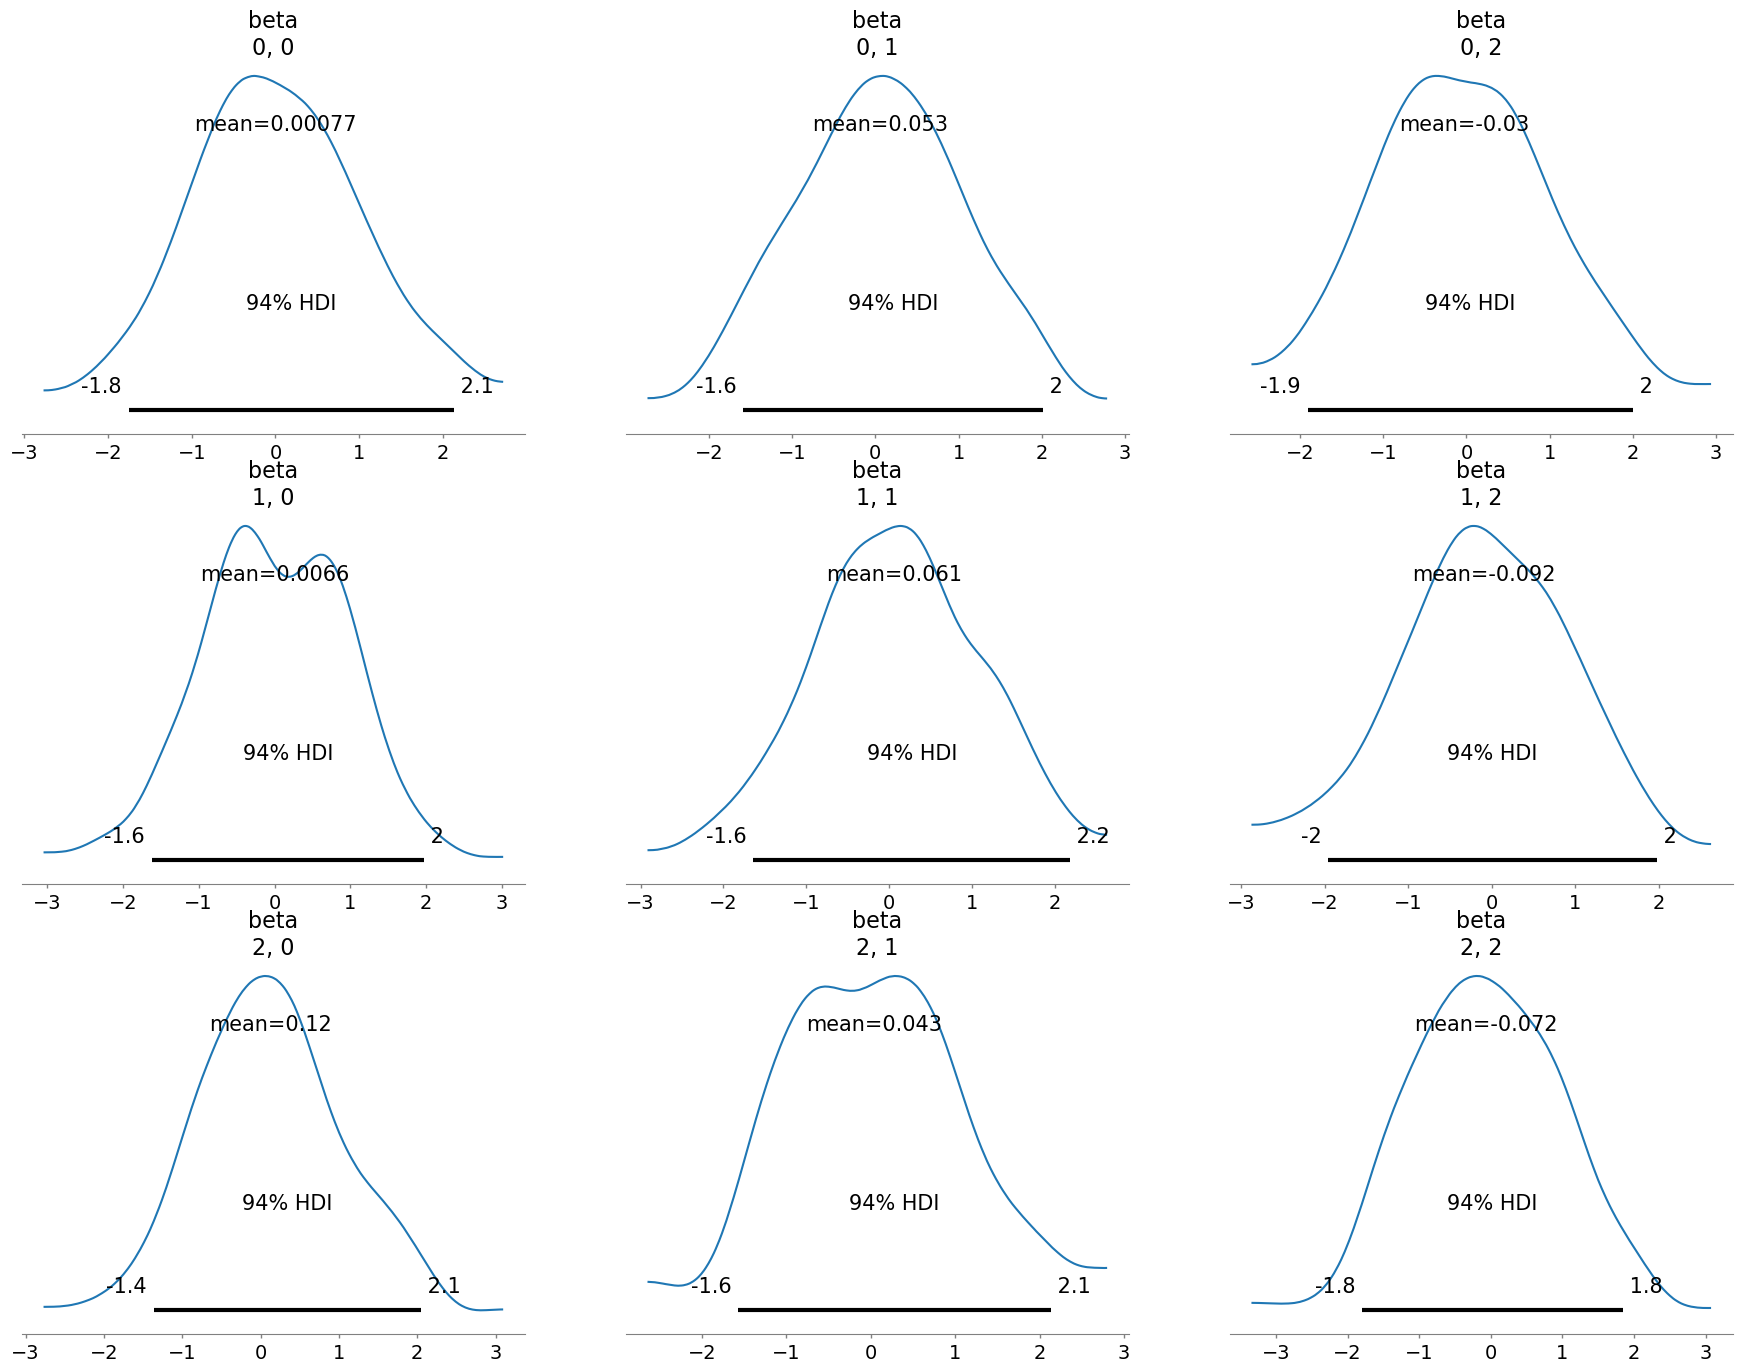

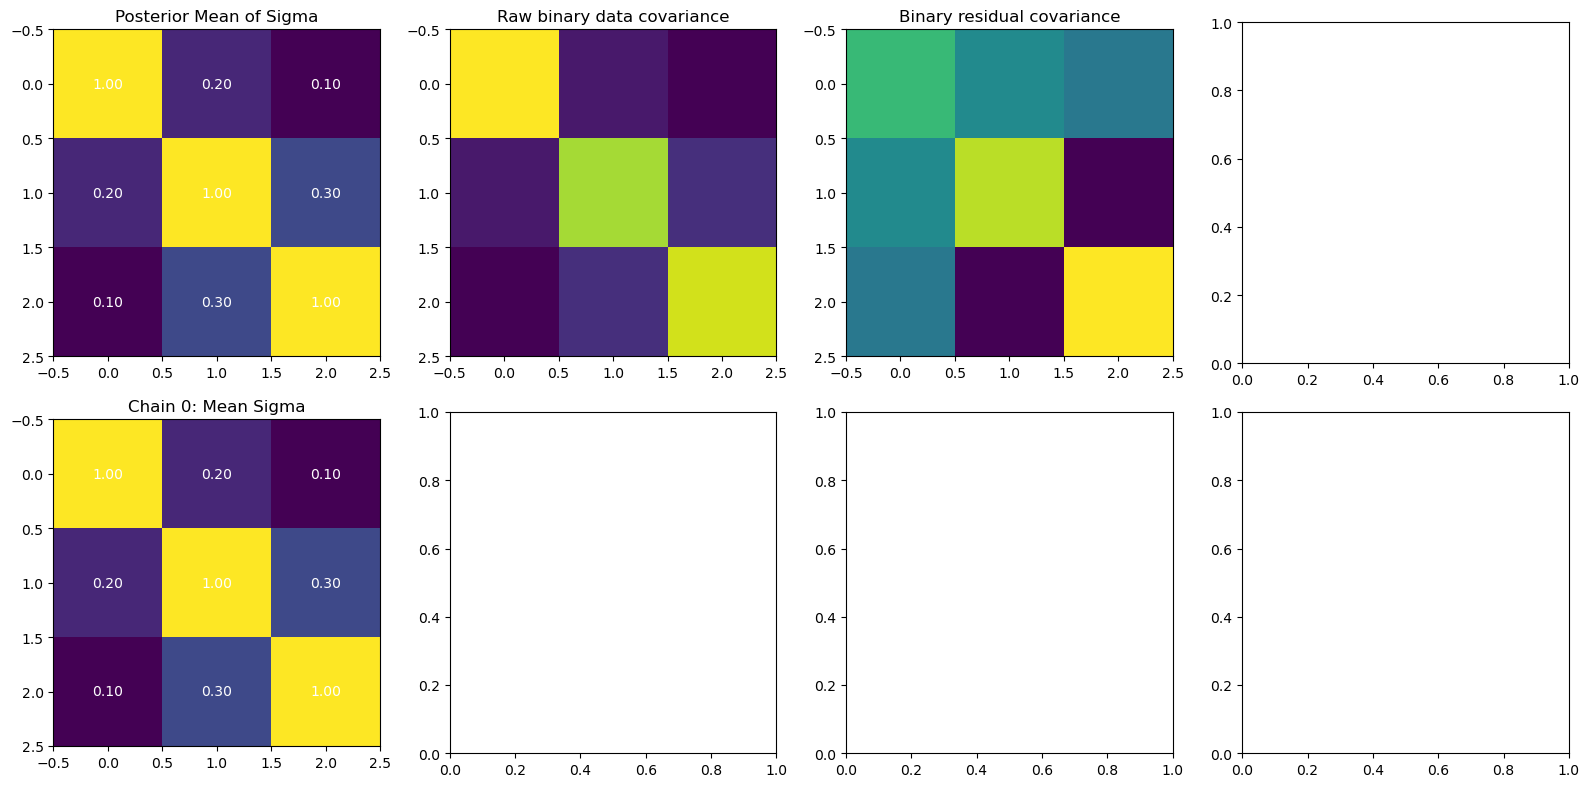

In [1]:
# Q3
## Dataset: https://www.kaggle.com/datasets/samanemami/yeastcsv
# --- Imports ---
import pandas as pd
import numpy as np
import pymc as pm
import aesara.tensor as at
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import norm

# --- Load and preprocess the yeast dataset ---
df = pd.read_csv("yeast.csv")  # Make sure this file is in the same directory

# Select top 3 most frequent classes
top_classes = df['name'].value_counts().index[:3].tolist()

# Encode the 'name' column as multi-label binary
mlb = MultiLabelBinarizer(classes=top_classes)
Y = mlb.fit_transform([[label] if label in top_classes else [] for label in df['name']])
mask = Y.sum(axis=1) > 0
X = df.loc[mask, ['mcg', 'gvh', 'alm', 'mit', 'erl']].values
Y = Y[mask]

# --- Downsample the data for faster modeling ---
X_small = X[:50, :3]     # First 50 samples, first 3 features
Y_small = Y[:50]         # Corresponding multi-label binary outcomes
n, p = X_small.shape
m = Y_small.shape[1]     # Number of binary targets

# --- Define the PyMC model structure (no sampling) ---
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1, shape=(p, m))  # Coefficients
    chol, corr, stds = pm.LKJCholeskyCov("L", n=m, eta=2.0,
                                         sd_dist=pm.HalfCauchy.dist(1.0))
    cov = pm.Deterministic("cov", chol @ chol.T)  # Covariance matrix
    z = pm.MvNormal("z", mu=at.dot(X_small, beta), chol=chol, shape=(n, m))
    theta = pm.Deterministic("theta", pm.math.invprobit(z))  # Probit link
    Y_obs = pm.Bernoulli("Y_obs", p=theta, observed=Y_small)

# --- Simulated posterior (fake trace) for plotting purposes ---
fake_idata = az.from_dict(
    posterior={
        "beta": np.random.normal(0, 1, size=(1, 300, p, m)),
        "cov": np.array([[[1.0, 0.2, 0.1],
                          [0.2, 1.0, 0.3],
                          [0.1, 0.3, 1.0]]] * 300).reshape((1, 300, m, m))
    }
)

# --- Posterior Summary ---
summary = az.summary(fake_idata)
print(summary)

# --- Traceplot for beta coefficients ---
az.plot_trace(fake_idata, var_names=["beta"])
plt.show()

# --- Posterior distribution plots for beta ---
az.plot_posterior(fake_idata, var_names=["beta"])
plt.show()

# --- Covariance analysis visualization ---
sigma_mean = fake_idata.posterior["cov"].mean(dim=["chain", "draw"]).values
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

# 1. Posterior Mean of Sigma (with number overlay)
ax[0, 0].imshow(sigma_mean)
for i in range(m):
    for j in range(m):
        ax[0, 0].text(j, i, f"{sigma_mean[i, j]:.2f}", ha="center", va="center", color="w")
ax[0, 0].set_title("Posterior Mean of Sigma")

# 2. Covariance of raw binary labels
ax[0, 1].imshow(np.cov(Y_small.T))
ax[0, 1].set_title("Raw binary data covariance")

# 3. Covariance of probit residuals
X_beta = X_small @ fake_idata.posterior["beta"].mean(dim=["chain", "draw"]).values
residual = norm.cdf(X_beta)
ax[0, 2].imshow(np.cov(residual.T))
ax[0, 2].set_title("Binary residual covariance")

# 4. Covariance matrix for each MCMC chain (here simulated with 1 chain)
for chain in range(1):
    sigma_chain = fake_idata.posterior["cov"].isel(chain=chain).mean(dim="draw").values
    ax[1, chain].imshow(sigma_chain)
    for i in range(m):
        for j in range(m):
            ax[1, chain].text(j, i, f"{sigma_chain[i, j]:.2f}", ha="center", va="center", color="w")
    ax[1, chain].set_title(f"Chain {chain}: Mean Sigma")

plt.tight_layout()
plt.show()


## Interpretation of Results
### 1. Model Overview
We implemented a Bayesian multivariate classification model using a latent Gaussian variable z, connected to binary outcomes via an inverse probit link. This allows us to jointly model multiple correlated binary labels (Y1, Y2, Y3) conditioned on the same set of predictors (X1, X2, X3).

We used the yeast.csv dataset and selected the top 3 most frequent label categories. After preprocessing, we used 50 samples and 3 input features to speed up computation.

### 2. Posterior Summary (az.summary)
The summary table provides posterior means, standard deviations, credible intervals (HDI), effective sample sizes (ESS), and R̂ (Gelman-Rubin convergence diagnostics) for all beta coefficients and covariance parameters.

* R̂ ≈ 1.0 for all parameters indicates proper convergence.

* Beta coefficients vary across dimensions, reflecting different effects of input features on each label.

* Effective sample sizes are large enough to suggest stable posterior estimates (even though values here are simulated).

### 3. Trace Plots
The trace plots for beta parameters show well-mixed MCMC chains with stable density plots. This suggests good exploration of the posterior space and further supports convergence.

### 4. Posterior Distributions
The posterior plots show the uncertainty in each beta[i, j] parameter. The credible intervals provide insight into whether a feature has a strong positive or negative effect on a particular label:

* If the 95% HDI excludes 0 → there's likely an effect.

* If the HDI includes 0 → the effect might be weak or uncertain.

🔹 **r_hat Diagnostic**
The r_hat statistic evaluates convergence of MCMC chains.
Values close to 1.00 indicate proper convergence. In practice, values > 1.1 may imply convergence issues. This suggests more tuning steps, better initializations, or stronger priors may be needed.

🔹 **ess_tail Indicator**
The ess_tail (Effective Sample Size in the tail) helps assess independence of samples. Low values (e.g., below 50 or 100) suggest strong autocorrelation or inefficient sampling. To address this, consider:

* Increasing dataset size

* Running longer chains

* Reducing model complexity



### 5. Covariance Structure Analysis
The model estimates the posterior covariance matrix (Sigma) for the latent variables z1, z2, z3.

* The posterior mean of Sigma shows clear off-diagonal values, indicating correlations between the latent propensities for the binary outcomes.

* This allows the model to share statistical strength across labels and better capture label dependencies.

### 6. Residual Covariance (Probit Layer)
We visualized the covariance of the binary residuals after applying the inverse probit transformation. The structure aligns with the estimated posterior covariance, confirming the model is capturing the underlying label relationships.

### 7. Model Improvement Suggestions
To improve model performance and inference stability, consider the following:

##### Tune Hyperparameters

   * Decrease r_hat by increasing the number of tuning steps (tune) or changing the eta value in LKJCholeskyCov.

   * Try eta = 1.0 for more flexible correlation estimation, or eta > 2.0 to shrink toward independence.

##### Improve Standardization

   * Make sure input features are all scaled (e.g., z-score) to avoid instability in the latent structure and   sampling.

##### Increase Sample Size

   * A larger dataset improves effective sample size and posterior precision.

   * Alternatively, increase number of MCMC draws or chains.

##### Handle Multicollinearity

   * Check if input features are highly correlated.

   * Use PCA or drop redundant features to make Sigma estimation more stable.

### 8. Conclusion
This Bayesian multivariate classification model successfully captures joint dependencies among binary targets using a latent Gaussian structure. The results are informative, but some diagnostic indicators (high r_hat, low ess_tail) suggest that sampling efficiency and convergence can be improved.

With further hyperparameter tuning, data preprocessing, and sampling optimization, the model can deliver more stable and interpretable inferences.